In [16]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from collections import Counter
from matplotlib.lines import Line2D
import lmfit
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.options.mode.copy_on_write = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.optimize import fsolve
import tensorflow as tf

In [17]:
## Common function for reading files and preprocessing data
#def read_fits_and_cut(input_file_name):
#    table = Table.read(input_file_name)
#    df = table.to_pandas()
#    df['id'] = df['id'].astype(str)
#    for column in df.columns:
#        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
#            df[column] = df[column].str.decode('utf-8')
#    df['g0'] = df['gpsf'] - df['a_g'] #a_g: galactic extinction in g band (HSC has girn-band)
#    df['i0'] = df['ipsf'] - df['a_i']
#    df['n0'] = df['npsf'] - df['a_n']
#    df['MGH'] = df['MGFE'] + df['FEH']
#    #df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)] #or df = df[(-0.80 <= df['MGFE']) & (df['MGFE'] < 1.20)]
#    return df

def read_fits_and_cut_plus(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    df.drop(['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFE', 'ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR'], axis=1, inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)]
    return df
    
def read_hsc(input_file_name):
    data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
    df = data.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    return df

def read_hsc_members(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    return df

In [18]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_HSC_DEIMOS_plus_w_age.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_HSC_DEIMOS_plus_w_age.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_HSC_DEIMOS_plus_w_age.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_HSC_DEIMOS_plus_w_age.csv')
print(f'len(fnx) = {len(fnx)}') #485 -> 308
print(f'len(scl) = {len(scl)}') #405 -> 283
print(f'len(umi) = {len(umi)}') #263 -> 93
print(f'len(dra) = {len(dra)}') #168 -> 93

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #23089
print(f'len(hsc_scl) = {len(hsc_scl)}') #2137
print(f'len(hsc_umi) = {len(hsc_umi)}') #921
print(f'len(hsc_dra) = {len(hsc_dra)}') #478

len(fnx) = 308
len(scl) = 283
len(umi) = 93
len(dra) = 93
len(hsc_fnx) = 23089
len(hsc_scl) = 2137
len(hsc_umi) = 921
len(hsc_dra) = 478


In [19]:
fnx_e = fnx[fnx['by'] == 'Evan']
fnx_l = fnx[fnx['by'] == 'Lauren']

scl_e = scl[scl['by'] == 'Evan']
scl_l = scl[scl['by'] == 'Lauren']

umi_e = umi[umi['by'] == 'Evan']
umi_l = umi[umi['by'] == 'Lauren']

dra_e = dra[dra['by'] == 'Evan']
dra_l = dra[dra['by'] == 'Lauren']

In [20]:
# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

In [21]:
xmin, xmax = 0.4, 2

Mg0_max = -0.20 ; Mn0_max = -0.30 ; Mi0_max = -1.18
fnx_mag = fnx[(xmin < fnx['Mg0']-fnx['Mi0']) & (fnx['Mg0']-fnx['Mi0'] < xmax) & (fnx['Mg0'] < Mg0_max) & (fnx['Mn0'] < Mn0_max) & (fnx['Mi0'] < Mi0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['Mg0']-hsc_fnx['Mi0']) & (hsc_fnx['Mg0']-hsc_fnx['Mi0'] < xmax) & (hsc_fnx['Mg0'] < Mg0_max) & (hsc_fnx['Mn0'] < Mn0_max) & (hsc_fnx['Mi0'] < Mi0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

Mg0_max = 0.18 ; Mn0_max = 0.08 ; Mi0_max = -0.70
scl_mag = scl[(xmin < scl['Mg0']-scl['Mi0']) & (scl['Mg0']-scl['Mi0'] < xmax) & (scl['Mg0'] < Mg0_max) & (scl['Mn0'] < Mn0_max) & (scl['Mi0'] < Mi0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['Mg0']-hsc_scl['Mi0']) & (hsc_scl['Mg0']-hsc_scl['Mi0'] < xmax) & (hsc_scl['Mg0'] < Mg0_max) & (hsc_scl['Mn0'] < Mn0_max) & (hsc_scl['Mi0'] < Mi0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

Mg0_max = 1.00 ; Mn0_max = 0.85 ; Mi0_max = 0.15
umi_mag = umi[(xmin < umi['Mg0']-umi['Mi0']) & (umi['Mg0']-umi['Mi0'] < xmax) & (umi['Mg0'] < Mg0_max) & (umi['Mn0'] < Mn0_max) & (umi['Mi0'] < Mi0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['Mg0']-hsc_umi['Mi0']) & (hsc_umi['Mg0']-hsc_umi['Mi0'] < xmax) & (hsc_umi['Mg0'] < Mg0_max) & (hsc_umi['Mn0'] < Mn0_max) & (hsc_umi['Mi0'] < Mi0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

Mg0_max = 0.65 ; Mn0_max = 0.50 ; Mi0_max = -0.20
dra_mag = dra[(xmin < dra['Mg0']-dra['Mi0']) & (dra['Mg0']-dra['Mi0'] < xmax) & (dra['Mg0'] < Mg0_max) & (dra['Mn0'] < Mn0_max) & (dra['Mi0'] < Mi0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['Mg0']-hsc_dra['Mi0']) & (hsc_dra['Mg0']-hsc_dra['Mi0'] < xmax) & (hsc_dra['Mg0'] < Mg0_max) & (hsc_dra['Mn0'] < Mn0_max) & (hsc_dra['Mi0'] < Mi0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251
len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132
len(umi_mag) = 93 -> 88
len(hsc_umi_mag) = 921 -> 593
len(dra_mag) = 93 -> 90
len(hsc_dra_mag) = 478 -> 342


In [22]:
# Combine DEIMOS
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

# Combine HSC
frame = [hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag]
hsc_df_mag = pd.concat(frame, ignore_index=True)
print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name'])) #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})

len(df_mag) = 741
Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})


In [23]:
print("FEH at 120th element:", df_mag.iloc[480]['FEH'])
print("FEHERR at 120th element:", df_mag.iloc[480]['FEHERR'])

FEH at 120th element: -1.292145736607899
FEHERR at 120th element: 0.1015029500080235


Training sample size = 592
Test sample size = 149 



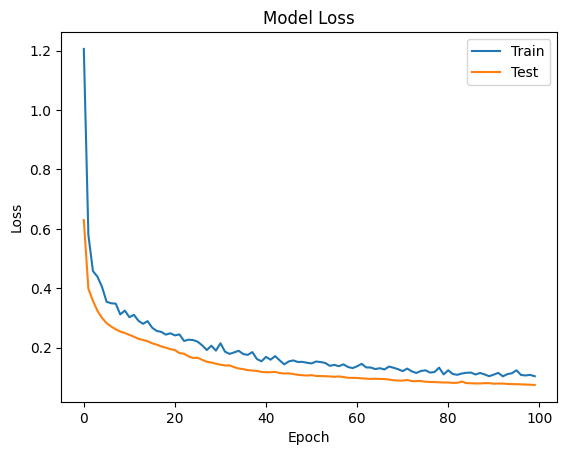

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
test_err_FEH : 0.104
test_err_MGH : 0.234
rmse_FEH of test results : 0.247
rmse_MGH of test results : 0.334
chi_sq_test_FEH : 0.409
chi_sq_test_MGH : 1.099
mean Y_pred_FEH_uncertainty :0.371
mean Y_pred_MGH_uncertainty :0.218


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
train_err_FEH : 0.105
train_err_MGH : 0.222
rmse_train_FEH of training results : 0.283
rmse_train_MGH of training results : 0.267
chi_sq_training_FEH : 0.457
chi_sq_training_MGH : 0.626
mean Y_train_pred_FEH_uncertainty :0.402
mean Y_train_pred_MGH_uncertainty :0.250


mean uncertainty_FEH_phot_ann :0.184
mean uncertainty_MGH_phot_ann :0.146
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342}) 

CPU times: user 1min 2s, sys: 17.3 s, total: 1min 19s
Wall time: 27.9 s


In [24]:
%%time
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## HSC-DEIMOS -> HSC (Fnx+Scl+UMi+Dra)
# Train and predict FEH and MGH
df_mag_ohe = pd.get_dummies(df_mag, columns=['DSPH'])
df_X = np.column_stack((
    df_mag['Mg0'], 
    df_mag['Mg0'] - df_mag['Mi0'], 
    df_mag['Mg0'] - df_mag['Mn0']#, 
    #df_mag_ohe[['DSPH_for', 'DSPH_scl', 'DSPH_umi', 'DSPH_dra']].values
))
df_Y = np.column_stack((df_mag['FEH'], df_mag['MGH']))
indices = df_mag.index
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)
idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
print('Training sample size =', len(X_train)) #592
print('Test sample size =', len(X_test), '\n') #149

# Define ANN model
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.2),  # Dropout 추가
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),  # Dropout 추가
    keras.layers.Dense(2)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Error of test sample
Y_pred = model.predict(X_test)
test_err_FEH = df_mag.loc[idx_test, 'FEHERR']
test_err_MGH = df_mag.loc[idx_test, 'MGHERR']
pd.set_option('display.float_format', '{:.15f}'.format)
print('test_err_FEH : {0:.3f}'.format(test_err_FEH.mean())) #0.104
print('test_err_MGH : {0:.3f}'.format(test_err_MGH.mean())) #0.234
# rmse of test sample
mse_FEH = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
mse_MGH = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
rmse_FEH = math.sqrt(mse_FEH)
rmse_MGH = math.sqrt(mse_MGH)
print('rmse_FEH of test results : {0:.3f}'.format(rmse_FEH)) #0.
print('rmse_MGH of test results : {0:.3f}'.format(rmse_MGH)) #0.
# calculate chi-square of test sample
Y_pred_uncertainty = np.std(Y_pred, axis=0)
chi_sq_test_FEH = np.sum((Y_pred[:, 0] - Y_test[:, 0])**2 / (test_err_FEH**2 + Y_pred_uncertainty[0]**2))  / len(Y_test[:, 0])
chi_sq_test_MGH = np.sum((Y_pred[:, 1] - Y_test[:, 1])**2 / (test_err_MGH**2 + Y_pred_uncertainty[1]**2))  / len(Y_test[:, 1])
print('chi_sq_test_FEH : {0:.3f}'.format(chi_sq_test_FEH)) #0.
print('chi_sq_test_MGH : {0:.3f}'.format(chi_sq_test_MGH)) #1.
print('mean Y_pred_FEH_uncertainty :{0:.3f}'.format(Y_pred_uncertainty[0])) #0.
print('mean Y_pred_MGH_uncertainty :{0:.3f}'.format(Y_pred_uncertainty[1])) #0.
print('\n')

# Error of training sample
Y_train_pred = model.predict(X_train)
train_err_FEH = df_mag.loc[idx_train, 'FEHERR']
train_err_MGH = df_mag.loc[idx_train, 'MGHERR']
print('train_err_FEH : {0:.3f}'.format(train_err_FEH.mean())) #0.105
print('train_err_MGH : {0:.3f}'.format(train_err_MGH.mean())) #0.222
# rmse of training sample
mse_train_FEH = mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
mse_train_MGH = mean_squared_error(Y_train[:, 1], Y_train_pred[:, 1])
rmse_train_FEH = math.sqrt(mse_train_FEH)
rmse_train_MGH = math.sqrt(mse_train_MGH)
print('rmse_train_FEH of training results : {0:.3f}'.format(rmse_train_FEH)) #0.
print('rmse_train_MGH of training results : {0:.3f}'.format(rmse_train_MGH)) #0.
# Calculate chi-square of training sample
Y_train_pred_uncertainty = np.std(Y_train_pred, axis=0)
chi_sq_training_FEH = np.sum((Y_train_pred[:, 0] - Y_train[:, 0])**2 / (train_err_FEH**2 + Y_train_pred_uncertainty[0]**2)) / len(Y_train[:, 0])
chi_sq_training_MGH = np.sum((Y_train_pred[:, 1] - Y_train[:, 1])**2 / (train_err_MGH**2 + Y_train_pred_uncertainty[1]**2)) / len(Y_train[:, 1])
print('chi_sq_training_FEH : {0:.3f}'.format(chi_sq_training_FEH)) #0.
print('chi_sq_training_MGH : {0:.3f}'.format(chi_sq_training_MGH)) #0.
print('mean Y_train_pred_FEH_uncertainty :{0:.3f}'.format(Y_train_pred_uncertainty[0])) #0.
print('mean Y_train_pred_MGH_uncertainty :{0:.3f}'.format(Y_train_pred_uncertainty[1])) #0.
print('\n')

## Fitting to the HSC data
hsc_df_mag_ohe = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_df_X = np.column_stack((
    hsc_df_mag['Mg0'], 
    hsc_df_mag['Mg0']-hsc_df_mag['Mi0'],
    hsc_df_mag['Mg0']-hsc_df_mag['Mn0']#,
    #hsc_df_mag_ohe[['name_for', 'name_scl', 'name_umi', 'name_dra']].values
))

def predict_with_uncertainty(model, X, n_iter=100):
    predictions = np.zeros((n_iter, X.shape[0], 2))

    for i in range(n_iter):
        predictions[i] = model(X, training=True).numpy()

    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    
    return pred_mean, pred_std

n_iter = 100
pred_mean, pred_std = predict_with_uncertainty(model, hsc_df_X, n_iter)
hsc_df_mag['FEH_phot_ann'] = pred_mean[:, 0]
hsc_df_mag['MGH_phot_ann'] = pred_mean[:, 1]
hsc_df_mag['uncertainty_FEH_phot_ann'] = pred_std[:, 0]
hsc_df_mag['uncertainty_MGH_phot_ann'] = pred_std[:, 1]
print('mean uncertainty_FEH_phot_ann :{0:.3f}'.format(hsc_df_mag['uncertainty_FEH_phot_ann'].mean())) #0.180
print('mean uncertainty_MGH_phot_ann :{0:.3f}'.format(hsc_df_mag['uncertainty_MGH_phot_ann'].mean())) #0.136

print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name']), '\n') #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342}) 

# ---------------------------------------------------------------------------------------------------------------------------------
# Train and predict MGFE
for i in range(6):
    hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']
    hsc_df_mag['uncertainty_MGFE_phot_ann'] = np.sqrt(np.abs(hsc_df_mag['uncertainty_MGH_phot_ann']**2 - hsc_df_mag['uncertainty_FEH_phot_ann']**2))

# Re-call each galaxy's name
hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']


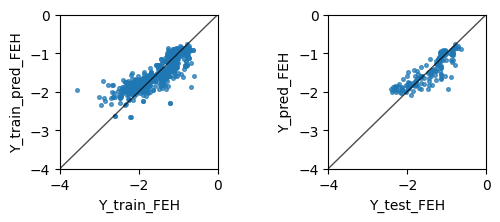

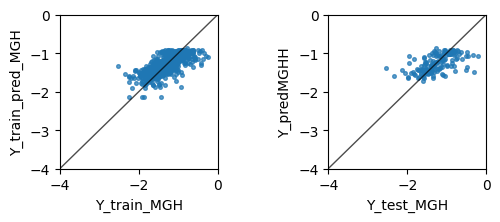

In [25]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 0], Y_train_pred[:, 0], s=7, alpha=.7)
ax0.set_xlabel('Y_train_FEH') ; ax0.set_ylabel('Y_train_pred_FEH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 0], Y_pred[:, 0], s=7, alpha=.7)
ax1.set_xlabel('Y_test_FEH') ; ax1.set_ylabel('Y_pred_FEH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 1], Y_train_pred[:, 1], s=7, alpha=.7)
ax0.set_xlabel('Y_train_MGH') ; ax0.set_ylabel('Y_train_pred_MGH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 1], Y_pred[:, 1], s=7, alpha=.7)
ax1.set_xlabel('Y_test_MGH') ; ax1.set_ylabel('Y_predMGHH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

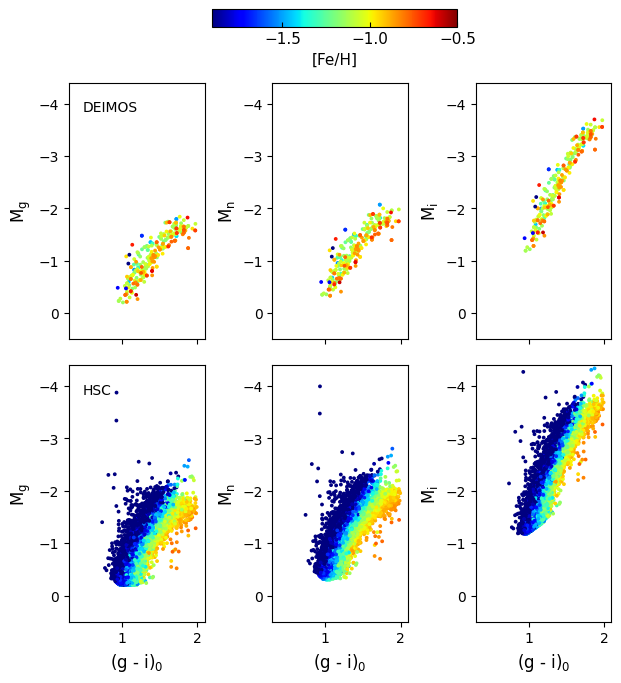

In [26]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)

plt.show()

Training sample size = 592
Test sample size = 149 

Epoch 0/100, Train Loss: 1.2316, Val Loss: 0.5473
Epoch 10/100, Train Loss: 0.1803, Val Loss: 0.1248
Epoch 20/100, Train Loss: 0.1555, Val Loss: 0.1042
Epoch 30/100, Train Loss: 0.1406, Val Loss: 0.0954
Epoch 40/100, Train Loss: 0.1280, Val Loss: 0.0926
Epoch 50/100, Train Loss: 0.1188, Val Loss: 0.0909
Epoch 60/100, Train Loss: 0.1144, Val Loss: 0.0894
Epoch 70/100, Train Loss: 0.1017, Val Loss: 0.0873
Epoch 80/100, Train Loss: 0.1004, Val Loss: 0.0880
Epoch 90/100, Train Loss: 0.0938, Val Loss: 0.0869


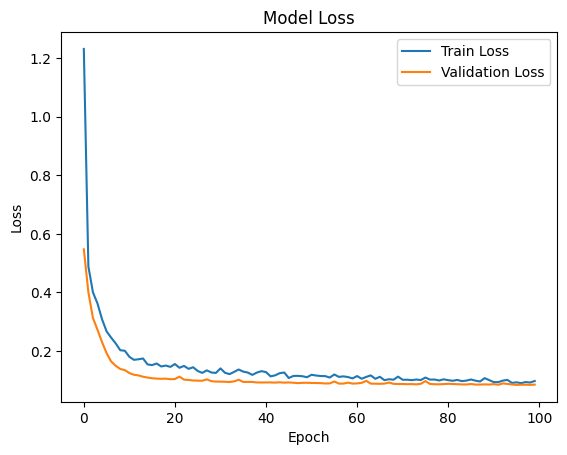

rmse_FEH of test results: 0.249
rmse_MGH of test results: 0.330
rmse_train_FEH of test results: 0.270
rmse_train_MGH of test results: 0.262
Mean uncertainty for FEH_phot_ann_pytorch: 0.167
Mean uncertainty for MGH_phot_ann_pytorch: 0.120
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342}) 

CPU times: user 6.1 s, sys: 27.8 ms, total: 6.12 s
Wall time: 6.05 s


In [27]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F

df_mag_ohe = pd.get_dummies(df_mag, columns=['DSPH'])
df_X = np.column_stack((
    df_mag['Mg0'], 
    df_mag['Mg0'] - df_mag['Mi0'], 
    df_mag['Mg0'] - df_mag['Mn0']
))
df_Y = np.column_stack((df_mag['FEH'], df_mag['MGH']))

indices = df_mag.index
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)
idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=42)

print('Training sample size =', len(X_train)) # 592
print('Test sample size =', len(X_test), '\n') # 149

# Convert to PyTorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Make a data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train.shape[1]
model = ANN(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learn model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Calculate loss validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor).item()
    
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict from test and train sample
model.eval()
with torch.no_grad():
    Y_pred = model(X_test_tensor).numpy()
    Y_train_pred = model(X_train_tensor).numpy()

# Get the RMSE of test sample
mse_FEH = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
mse_MGH = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
rmse_FEH = math.sqrt(mse_FEH)
rmse_MGH = math.sqrt(mse_MGH)
print(f'rmse_FEH of test results: {rmse_FEH:.3f}')
print(f'rmse_MGH of test results: {rmse_MGH:.3f}')

# Get the RMSE of training sample
mse_train_FEH = mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
mse_train_MGH = mean_squared_error(Y_train[:, 1], Y_train_pred[:, 1])
rmse_train_FEH = math.sqrt(mse_train_FEH)
rmse_train_MGH = math.sqrt(mse_train_MGH)
print(f'rmse_train_FEH of test results: {rmse_train_FEH:.3f}')
print(f'rmse_train_MGH of test results: {rmse_train_MGH:.3f}')


## Fitting to the HSC data
hsc_df_mag_ohe = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_df_X = np.column_stack((
    hsc_df_mag['Mg0'], 
    hsc_df_mag['Mg0']-hsc_df_mag['Mi0'],
    hsc_df_mag['Mg0']-hsc_df_mag['Mn0']#,
    #hsc_df_mag_ohe[['name_for', 'name_scl', 'name_umi', 'name_dra']].values
))



# Convert HSC dataset to PyTorch tensors
hsc_X_tensor = torch.tensor(hsc_df_X, dtype=torch.float32)

# Define function to estimate uncertainty using Monte Carlo Dropout
def predict_with_uncertainty(model, X, n_iter=100):
    model.train()  # Enable dropout during inference
    predictions = torch.zeros((n_iter, X.shape[0], 2))

    for i in range(n_iter):
        predictions[i] = model(X).detach()  # Perform stochastic forward pass

    pred_mean = predictions.mean(dim=0).numpy()
    pred_std = predictions.std(dim=0).numpy()

    return pred_mean, pred_std

# Perform prediction with uncertainty estimation
n_iter = 100
pred_mean, pred_std = predict_with_uncertainty(model, hsc_X_tensor, n_iter)

# Store predictions and uncertainties in the DataFrame
hsc_df_mag['FEH_phot_ann_pytorch'] = pred_mean[:, 0]
hsc_df_mag['MGH_phot_ann_pytorch'] = pred_mean[:, 1]
hsc_df_mag['uncertainty_FEH_phot_ann_pytorch'] = pred_std[:, 0]
hsc_df_mag['uncertainty_MGH_phot_ann_pytorch'] = pred_std[:, 1]

# Print mean uncertainty for reference
print('Mean uncertainty for FEH_phot_ann_pytorch: {:.3f}'.format(hsc_df_mag['uncertainty_FEH_phot_ann_pytorch'].mean()))
print('Mean uncertainty for MGH_phot_ann_pytorch: {:.3f}'.format(hsc_df_mag['uncertainty_MGH_phot_ann_pytorch'].mean()))

print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name']), '\n') #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342}) 

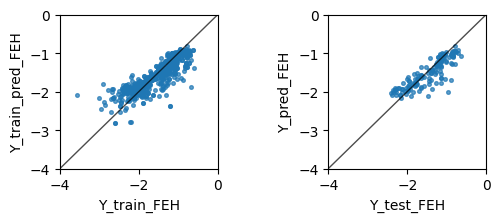

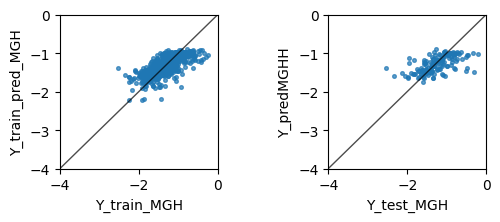

In [28]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 0], Y_train_pred[:, 0], s=7, alpha=.7)
ax0.set_xlabel('Y_train_FEH') ; ax0.set_ylabel('Y_train_pred_FEH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 0], Y_pred[:, 0], s=7, alpha=.7)
ax1.set_xlabel('Y_test_FEH') ; ax1.set_ylabel('Y_pred_FEH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 1], Y_train_pred[:, 1], s=7, alpha=.7)
ax0.set_xlabel('Y_train_MGH') ; ax0.set_ylabel('Y_train_pred_MGH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 1], Y_pred[:, 1], s=7, alpha=.7)
ax1.set_xlabel('Y_test_MGH') ; ax1.set_ylabel('Y_predMGHH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

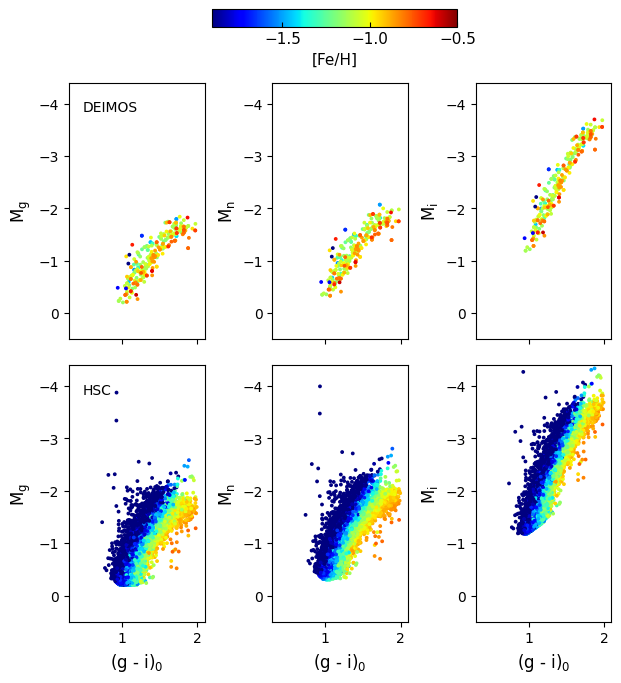

In [29]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)

plt.show()

Training sample size = 592
Test sample size = 149 



/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


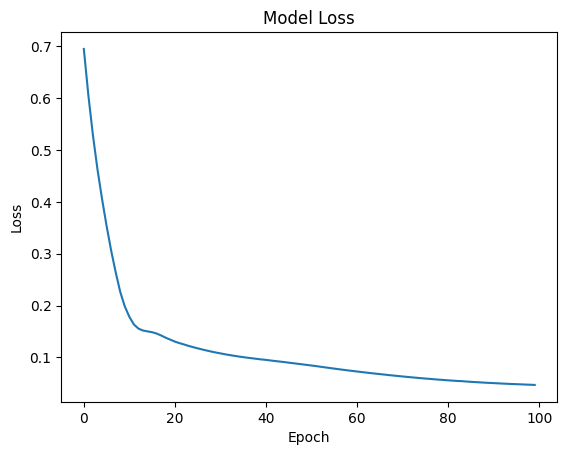

test_err_FEH : 0.104
test_err_MGH : 0.234
rmse_FEH of test results : 0.288
rmse_MGH of test results : 0.340


train_err_FEH : 0.105
train_err_MGH : 0.222
rmse_train_FEH of training results : 0.332
rmse_train_MGH of training results : 0.276


mean uncertainty_FEH_phot_ann_sklearn :0.000
mean uncertainty_MGH_phot_ann_sklearn :0.000


In [30]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

df_mag_ohe = pd.get_dummies(df_mag, columns=['DSPH'])
df_X = np.column_stack((
    df_mag['Mg0'], 
    df_mag['Mg0'] - df_mag['Mi0'], 
    df_mag['Mg0'] - df_mag['Mn0'], 
))
df_Y = np.column_stack((df_mag['FEH'], df_mag['MGH']))
indices = df_mag.index
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)
idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
print('Training sample size =', len(X_train)) #592
print('Test sample size =', len(X_test), '\n') #149

# Define MLP model
model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=100, random_state=42)

# Fit the model
model.fit(X_train, Y_train)

plt.plot(model.loss_curve_)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Error of test samples
Y_pred = model.predict(X_test)
test_err_FEH = df_mag.loc[idx_test, 'FEHERR']
test_err_MGH = df_mag.loc[idx_test, 'MGHERR']
pd.set_option('display.float_format', '{:.15f}'.format)
print('test_err_FEH : {0:.3f}'.format(test_err_FEH.mean())) #0.104
print('test_err_MGH : {0:.3f}'.format(test_err_MGH.mean())) #0.234
mse_FEH = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
mse_MGH = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
rmse_FEH = math.sqrt(mse_FEH)
rmse_MGH = math.sqrt(mse_MGH)
print('rmse_FEH of test results : {0:.3f}'.format(rmse_FEH)) #0.
print('rmse_MGH of test results : {0:.3f}'.format(rmse_MGH)) #0.
print('\n')

# Error of train samples
Y_train_pred = model.predict(X_train)
train_err_FEH = df_mag.loc[idx_train, 'FEHERR']
train_err_MGH = df_mag.loc[idx_train, 'MGHERR']
print('train_err_FEH : {0:.3f}'.format(train_err_FEH.mean())) #0.105
print('train_err_MGH : {0:.3f}'.format(train_err_MGH.mean())) #0.222
mse_train_FEH = mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
mse_train_MGH = mean_squared_error(Y_train[:, 1], Y_train_pred[:, 1])
rmse_train_FEH = math.sqrt(mse_train_FEH)
rmse_train_MGH = math.sqrt(mse_train_MGH)
print('rmse_train_FEH of training results : {0:.3f}'.format(rmse_train_FEH)) #0.
print('rmse_train_MGH of training results : {0:.3f}'.format(rmse_train_MGH)) #0.
print('\n')

# Fit to the HSC
hsc_df_mag_ohe = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_df_X = np.column_stack((
    hsc_df_mag['Mg0'], 
    hsc_df_mag['Mg0']-hsc_df_mag['Mi0'],
    hsc_df_mag['Mg0']-hsc_df_mag['Mn0']
))

def predict_with_uncertainty(model, X, n_iter=100):
    predictions = np.zeros((n_iter, X.shape[0], 2))

    for i in range(n_iter):
        predictions[i] = model.predict(X)

    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    
    return pred_mean, pred_std

n_iter = 100
pred_mean, pred_std = predict_with_uncertainty(model, hsc_df_X, n_iter)
hsc_df_mag['FEH_phot_ann_sklearn'] = pred_mean[:, 0]
hsc_df_mag['MGH_phot_ann_sklearn'] = pred_mean[:, 1]
hsc_df_mag['uncertainty_FEH_phot_ann_sklearn'] = pred_std[:, 0]
hsc_df_mag['uncertainty_MGH_phot_ann_sklearn'] = pred_std[:, 1]
print('mean uncertainty_FEH_phot_ann_sklearn :{0:.3f}'.format(hsc_df_mag['uncertainty_FEH_phot_ann_sklearn'].mean())) #0.180
print('mean uncertainty_MGH_phot_ann_sklearn :{0:.3f}'.format(hsc_df_mag['uncertainty_MGH_phot_ann_sklearn'].mean())) #0.136


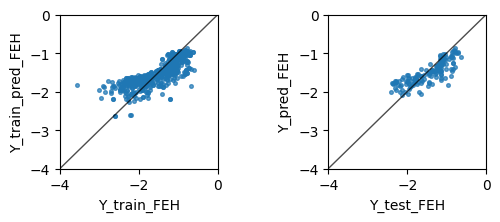

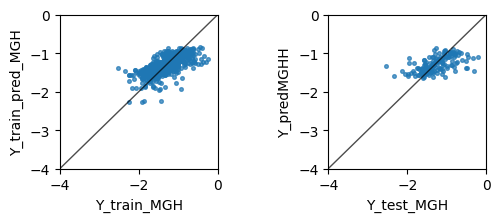

In [31]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 0], Y_train_pred[:, 0], s=7, alpha=.7)
ax0.set_xlabel('Y_train_FEH') ; ax0.set_ylabel('Y_train_pred_FEH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 0], Y_pred[:, 0], s=7, alpha=.7)
ax1.set_xlabel('Y_test_FEH') ; ax1.set_ylabel('Y_pred_FEH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.7})
ax0.scatter(Y_train[:, 1], Y_train_pred[:, 1], s=7, alpha=.7)
ax0.set_xlabel('Y_train_MGH') ; ax0.set_ylabel('Y_train_pred_MGH') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
ax1.scatter(Y_test[:, 1], Y_pred[:, 1], s=7, alpha=.7)
ax1.set_xlabel('Y_test_MGH') ; ax1.set_ylabel('Y_predMGHH') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)
plt.show()

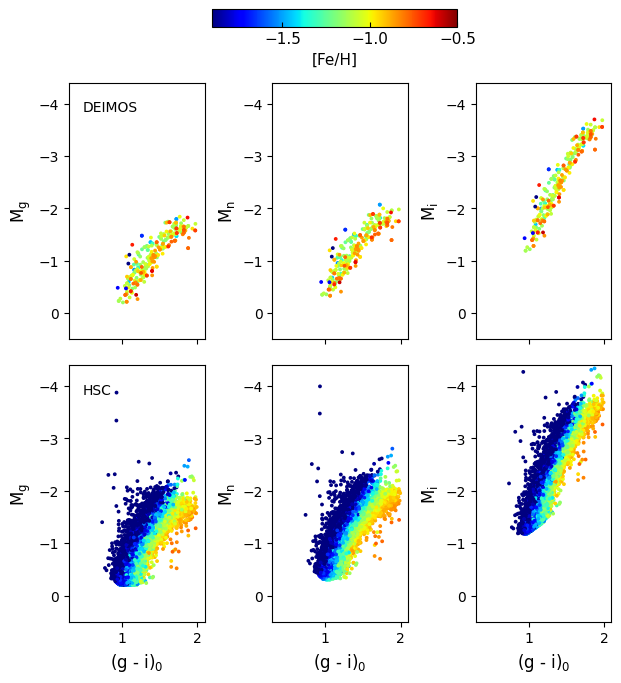

In [32]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)

plt.show()

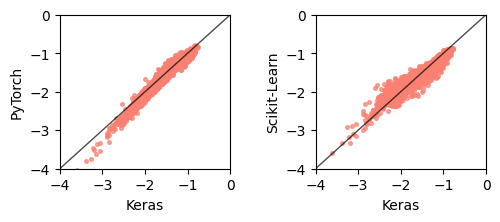

In [33]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5.5,2), gridspec_kw={'wspace':0.5})
ax0.scatter(hsc_df_mag['FEH_phot_ann'],hsc_df_mag['FEH_phot_ann_pytorch'], s=7, alpha=.7, color='salmon')
ax0.set_xlabel('Keras') ; ax0.set_ylabel('PyTorch') ; ax0.set_xlim([-4, 0]) ; ax0.set_ylim([-4, 0])
ax0.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)

ax1.scatter(hsc_df_mag['FEH_phot_ann'],hsc_df_mag['FEH_phot_ann_sklearn'], s=7, alpha=.7, color='salmon')
ax1.set_xlabel('Keras') ; ax1.set_ylabel('Scikit-Learn') ; ax1.set_xlim([-4, 0]) ; ax1.set_ylim([-4, 0])
ax1.plot(np.arange(-4, 0.5, 0.1), np.arange(-4, 0.5, 0.1), color='k', linewidth=1, alpha=.7)

plt.show()

In [ ]:
# bottom 그림에 세개 다 비교 

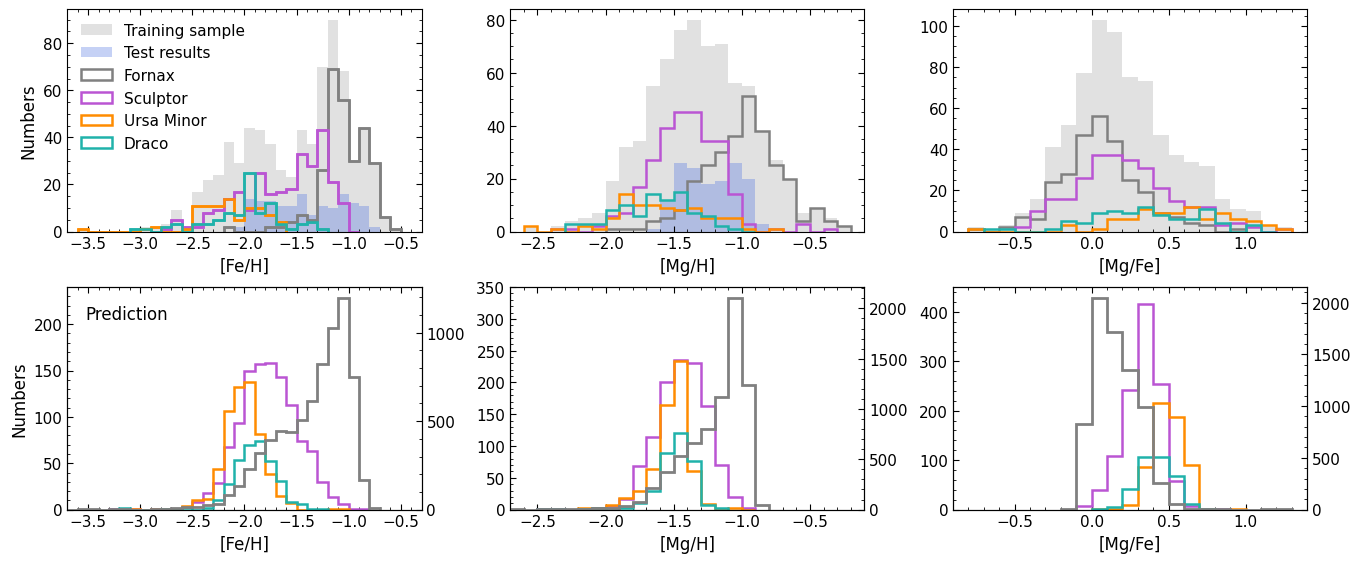

In [59]:
from matplotlib.ticker import MultipleLocator

def plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=1)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=1)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=2)
    plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})

bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Training sample')
ax0.hist(Y_pred[:, 0], bins=np.arange(np.floor(np.min(Y_pred[:, 0]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 0]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(Y_pred[:, 1], bins=np.arange(np.floor(np.min(Y_pred[:, 1]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 1]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row 
plot_with_twinx(ax3.twinx(), ax3, 
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_ylim([0, 240])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)
ax3.set_xlim([-3.7, -0.3])

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_ylim([0, 350])
ax4.set_xlim([-2.7, -0.1])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_ylim([0, 450])
ax5.set_xlim([-0.9, 1.4])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

# Save the plot
plt.savefig('compare_ann_feh_mgh_mgfe.png', bbox_inches='tight')

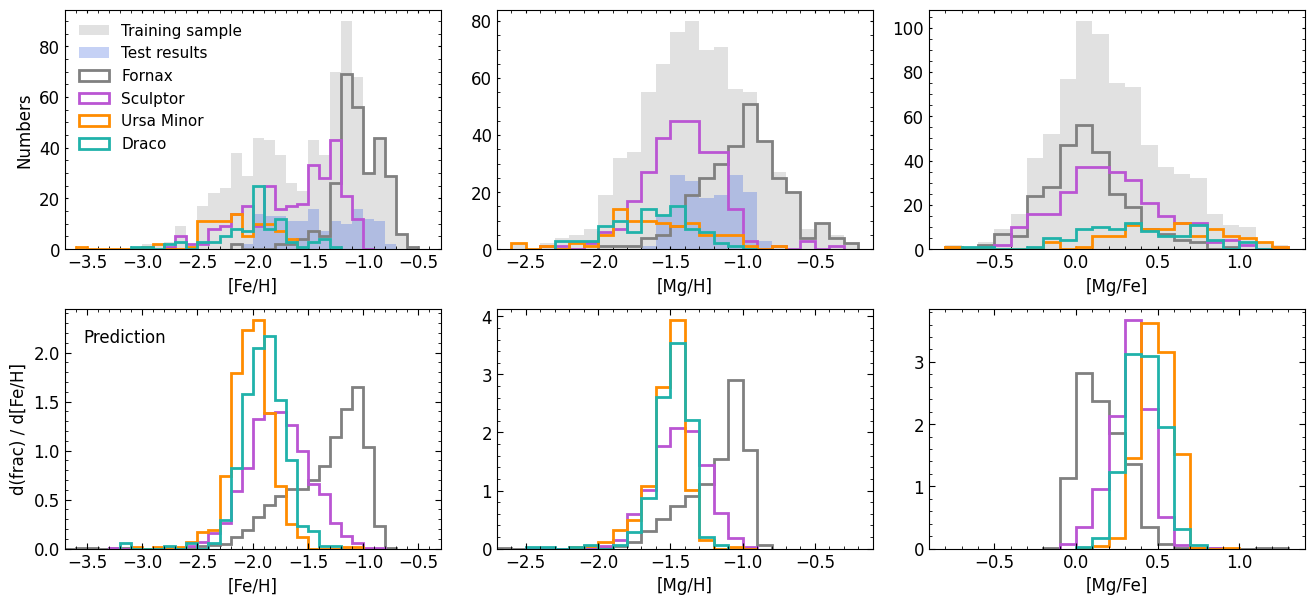

In [61]:
bins_width = 0.1
alpha = 1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 7), gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

data_dict_feh = {
    'Training sample': (df_mag['FEH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 0], 'royalblue', 0.3),
    'Fornax': (fnx_mag['FEH'], colors[0], alpha),
    'Sculptor': (scl_mag['FEH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['FEH'], colors[2], alpha),
    'Draco': (dra_mag['FEH'], colors[3], alpha)
}

data_dict_mgh = {
    'Training sample': (df_mag['MGH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 1], 'royalblue', 0.3),
    'Fornax': (fnx_mag['MGH'], colors[0], alpha),
    'Sculptor': (scl_mag['MGH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGH'], colors[2], alpha),
    'Draco': (dra_mag['MGH'], colors[3], alpha)
}

data_dict_mgfe = {
    'Training sample': (df_mag['MGFE'], 'dimgray', 0.2),
    'Fornax': (fnx_mag['MGFE'], colors[0], alpha),
    'Sculptor': (scl_mag['MGFE'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGFE'], colors[2], alpha),
    'Draco': (dra_mag['MGFE'], colors[3], alpha)
}

for data_dict, ax, xlabel in zip(
        [data_dict_feh, data_dict_mgh, data_dict_mgfe],  
        [ax0, ax1, ax2],  
        ['[Fe/H]', '[Mg/H]', '[Mg/Fe]']
):
    for label, (data, color, alpha_value) in data_dict.items():
        bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width, 
                         np.ceil(np.max(data) / bins_width) * bins_width + bins_width, 
                         bins_width)
        ax.hist(data, bins=bins, histtype='step' if label not in ['Training sample', 'Test results'] else 'stepfilled', color=color, alpha=alpha_value, label=label, linewidth=2)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel('')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_ylabel('Numbers', size=12)
ax0.legend(loc='upper left', frameon=False, fontsize=11)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)


def create_data_sets(data_dict, labels, colors):
    return [(data_dict[label], label, color) for label, color in zip(labels, colors)]

data_sets = [
    ('FEH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGFE_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag)
]

data_sets_list = []
for feature in data_sets:
    feature_name, *datasets = feature
    data_sets_list.append(create_data_sets({label: data[feature_name] for label, data in zip(labels, datasets)}, labels, colors))

def plot_histogram(ax, data, bins_width, label, color, alpha=0.8):
    color_dict = {
        'Fornax': 'gray',
        'Sculptor': 'mediumorchid',
        'Ursa Minor': 'darkorange',
        'Draco': 'lightseagreen',
        'Training sample': 'dimgray',
        'Test results': 'royalblue'
    }
    color = color_dict.get(label, 'gray')
    
    bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                     bins_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    frac_dfeh = counts / (len(data) * bins_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax.stairs(frac_dfeh, bin_edges, label=label, color=color, linewidth=2)
    
    return ax

def plot_data_on_ax(ax, data_sets, xlabel, ylabel, xticks=None):
    for data, label, color in data_sets:
        plot_histogram(ax, data, bins_width, label, color, alpha=alpha)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    
    if xticks:
        ax.set_xticks(xticks)

data_sets_0 = data_sets_list[0]
data_sets_1 = data_sets_list[1]
data_sets_2 = data_sets_list[2]
plot_data_on_ax(ax3, data_sets_0, '[Fe/H]', 'd(frac) / d[Fe/H]')
plot_data_on_ax(ax4, data_sets_1, '[Mg/H]', '')
plot_data_on_ax(ax5, data_sets_2, '[Mg/Fe]', '', xticks=[-0.5, 0.0, 0.5, 1.0])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)

ax0.set_xlim([-3.7, -0.3])
ax1.set_xlim([-2.7, -0.1])
ax2.set_xlim([-0.9, 1.4])
ax3.set_xlim([-3.7, -0.3])
ax4.set_xlim([-2.7, -0.1])
ax5.set_xlim([-0.9, 1.4])

plt.savefig('compare_ann_feh_mgh_mgfe_dfrac_dfeh.png', bbox_inches='tight')

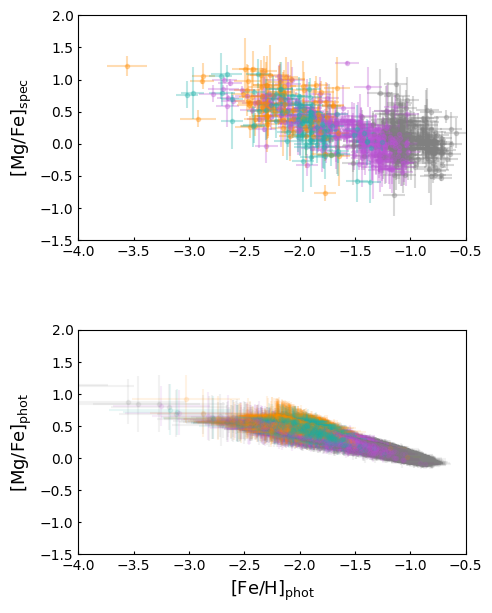

In [64]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 12
alpha = 0.3

# Spectroscopy
ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

# Photometry
ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['uncertainty_FEH_phot_ann'], yerr=hsc_fnx_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='gray')
ax1.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['uncertainty_FEH_phot_ann'], yerr=hsc_scl_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='mediumorchid')
ax1.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['uncertainty_FEH_phot_ann'], yerr=hsc_umi_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='darkorange')
ax1.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['uncertainty_FEH_phot_ann'], yerr=hsc_dra_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_together.png', bbox_inches='tight')

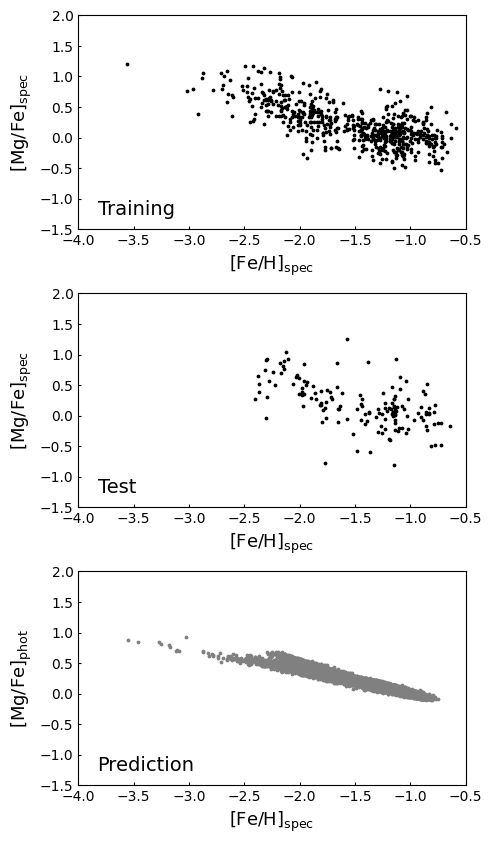

In [94]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.3})
s = 3 ; alpha = 1

ax0.scatter(Y_train[:, 0], Y_train[:, 1]-Y_train[:, 0], marker='o', s=s, alpha=alpha, color='k')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Training', ha='left', va='bottom', transform=ax0.transAxes, size=14)

ax1.scatter(Y_test[:, 0], Y_test[:, 1]-Y_test[:, 0], marker='o', s=s, alpha=alpha, color='k')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Test', ha='left', va='bottom', transform=ax1.transAxes, size=14)

ax2.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], marker='o', s=s, alpha=alpha, color='gray')
ax2.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], marker='o', s=s, alpha=alpha, color='gray')
ax2.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], marker='o', s=s, alpha=alpha, color='gray')
ax2.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], marker='o', s=s, alpha=alpha, color='gray')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, -0.5])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Prediction', ha='left', va='bottom', transform=ax2.transAxes, size=14)

plt.show()

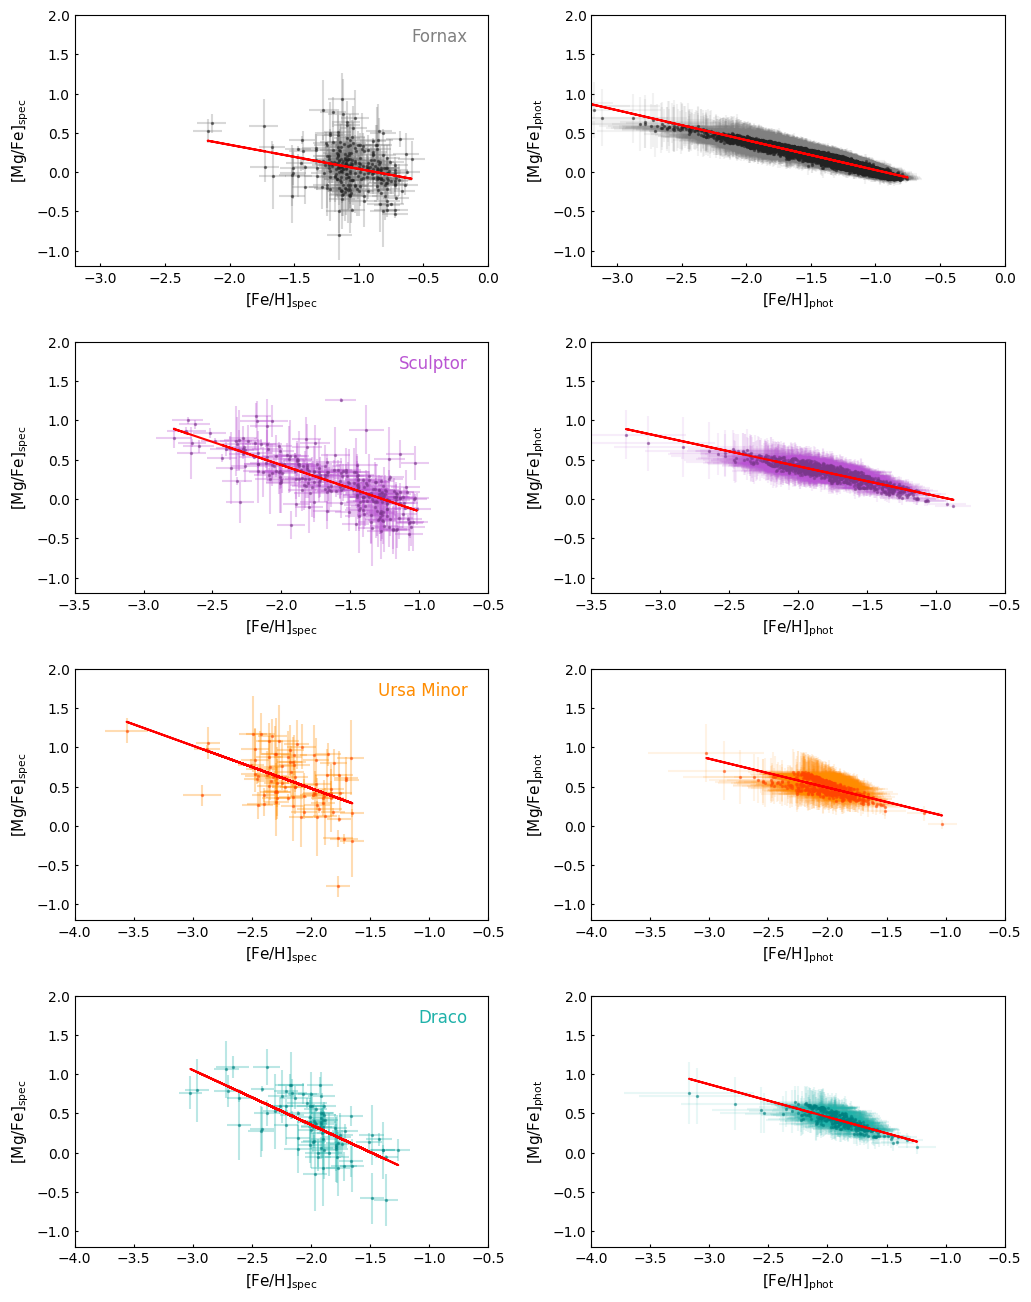

In [67]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12,16), gridspec_kw={'wspace':0.25, 'hspace':0.3})
s = 2 ; alpha = 0.5 ; markersize=0

# Fnx
ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='gray')
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax0.set_xlim([-3.2, 0])
ax0.set_ylim([-1.2, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.95, 0.95, 'Fornax', ha='right', va='top', transform=ax0.transAxes, color='gray', size=12)
slope_fnx, intercept_fnx = np.polyfit(fnx_mag['FEH'], fnx_mag['MGFE'], 1)
ax0.plot(fnx_mag['FEH'], slope_fnx * fnx_mag['FEH'] + intercept_fnx, color='red', lw=1.5, label='Trendline')

ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['uncertainty_FEH_phot_ann'], yerr=hsc_fnx_mag['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='gray')
ax1.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax1.set_xlim([-3.2, 0])
ax1.set_ylim([-1.2, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope_hsc_fnx, intercept_hsc_fnx = np.polyfit(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], 1)
ax1.plot(hsc_fnx_mag['FEH_phot_ann'], slope_hsc_fnx * hsc_fnx_mag['FEH_phot_ann'] + intercept_hsc_fnx, color='red', lw=1.5, label='Trendline')


# Scl
ax2.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='mediumorchid')
ax2.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax2.set_xlim([-3.5, -0.5])
ax2.set_ylim([-1.2, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.95, 0.95, 'Sculptor', ha='right', va='top', transform=ax2.transAxes, color='mediumorchid', size=12)
slope_scl, intercept_scl = np.polyfit(scl_mag['FEH'], scl_mag['MGFE'], 1)
ax2.plot(scl_mag['FEH'], slope_scl * scl_mag['FEH'] + intercept_scl, color='red', lw=1.5, label='Trendline')

ax3.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['uncertainty_FEH_phot_ann'], yerr=hsc_scl_mag['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='mediumorchid')
ax3.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax3.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax3.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax3.set_xlim([-3.5, -0.5])
ax3.set_ylim([-1.2, 2])
ax3.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax3.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope_hsc_scl, intercept_hsc_scl = np.polyfit(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], 1)
ax3.plot(hsc_scl_mag['FEH_phot_ann'], slope_hsc_scl * hsc_scl_mag['FEH_phot_ann'] + intercept_hsc_scl, color='red', lw=1.5, label='Trendline')


# UMi
ax4.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='darkorange')
ax4.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax4.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax4.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax4.set_xlim([-4, -0.5])
ax4.set_ylim([-1.2, 2])
ax4.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.text(0.95, 0.95, 'Ursa Minor', ha='right', va='top', transform=ax4.transAxes, color='darkorange', size=12)
slope_umi, intercept_umi = np.polyfit(umi_mag['FEH'], umi_mag['MGFE'], 1)
ax4.plot(umi_mag['FEH'], slope_umi * umi_mag['FEH'] + intercept_umi, color='red', lw=1.5, label='Trendline')

ax5.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['uncertainty_FEH_phot_ann'], yerr=hsc_umi_mag['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='darkorange')
ax5.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax5.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax5.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax5.set_xlim([-4, -0.5])
ax5.set_ylim([-1.2, 2])
ax5.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax5.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope_hsc_umi, intercept_hsc_umi = np.polyfit(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], 1)
ax5.plot(hsc_umi_mag['FEH_phot_ann'], slope_hsc_umi * hsc_umi_mag['FEH_phot_ann'] + intercept_hsc_umi, color='red', lw=1.5, label='Trendline')


# Dra
ax6.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='lightseagreen')
ax6.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax6.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax6.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax6.set_xlim([-4, -0.5])
ax6.set_ylim([-1.2, 2])
ax6.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.text(0.95, 0.95, 'Draco', ha='right', va='top', transform=ax6.transAxes, color='lightseagreen', size=12)
slope_dra, intercept_dra = np.polyfit(dra_mag['FEH'], dra_mag['MGFE'], 1)
ax6.plot(dra_mag['FEH'], slope_dra * dra_mag['FEH'] + intercept_dra, color='red', lw=1.5, label='Trendline')

ax7.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['uncertainty_FEH_phot_ann'], yerr=hsc_dra_mag['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='lightseagreen')
ax7.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax7.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax7.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax7.set_xlim([-4, -0.5])
ax7.set_ylim([-1.2, 2])
ax7.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax7.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope_hsc_dra, intercept_hsc_dra = np.polyfit(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], 1)
ax7.plot(hsc_dra_mag['FEH_phot_ann'], slope_hsc_dra * hsc_dra_mag['FEH_phot_ann'] + intercept_hsc_dra, color='red', lw=1.5, label='Trendline')

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh.png', bbox_inches='tight')

In [68]:
predicted_fnx_FEH = slope_fnx * fnx_mag['FEH'] + intercept_fnx
predicted_hsc_fnx_FEH = slope_hsc_fnx * hsc_fnx_mag['FEH_phot_ann'] + intercept_hsc_fnx
predicted_scl_FEH = slope_scl * scl_mag['FEH'] + intercept_scl
predicted_hsc_scl_FEH = slope_hsc_scl * hsc_scl_mag['FEH_phot_ann'] + intercept_hsc_scl
predicted_umi_FEH = slope_umi * umi_mag['FEH'] + intercept_umi
predicted_hsc_umi_FEH = slope_hsc_umi * hsc_umi_mag['FEH_phot_ann'] + intercept_hsc_umi
predicted_dra_FEH = slope_dra * dra_mag['FEH'] + intercept_dra
predicted_hsc_dra_FEH = slope_hsc_dra * hsc_dra_mag['FEH_phot_ann'] + intercept_hsc_dra

predicted_fnx_MGFE = slope_fnx * fnx_mag['MGFE'] + intercept_fnx
predicted_hsc_fnx_MGFE = slope_hsc_fnx * hsc_fnx_mag['MGFE_phot_ann'] + intercept_hsc_fnx
predicted_scl_MGFE = slope_scl * scl_mag['MGFE'] + intercept_scl
predicted_hsc_scl_MGFE = slope_hsc_scl * hsc_scl_mag['MGFE_phot_ann'] + intercept_hsc_scl
predicted_umi_MGFE = slope_umi * umi_mag['MGFE'] + intercept_umi
predicted_hsc_umi_MGFE = slope_hsc_umi * hsc_umi_mag['MGFE_phot_ann'] + intercept_hsc_umi
predicted_dra_MGFE = slope_dra * dra_mag['MGFE'] + intercept_dra
predicted_hsc_dra_MGFE = slope_hsc_dra * hsc_dra_mag['MGFE_phot_ann'] + intercept_hsc_dra

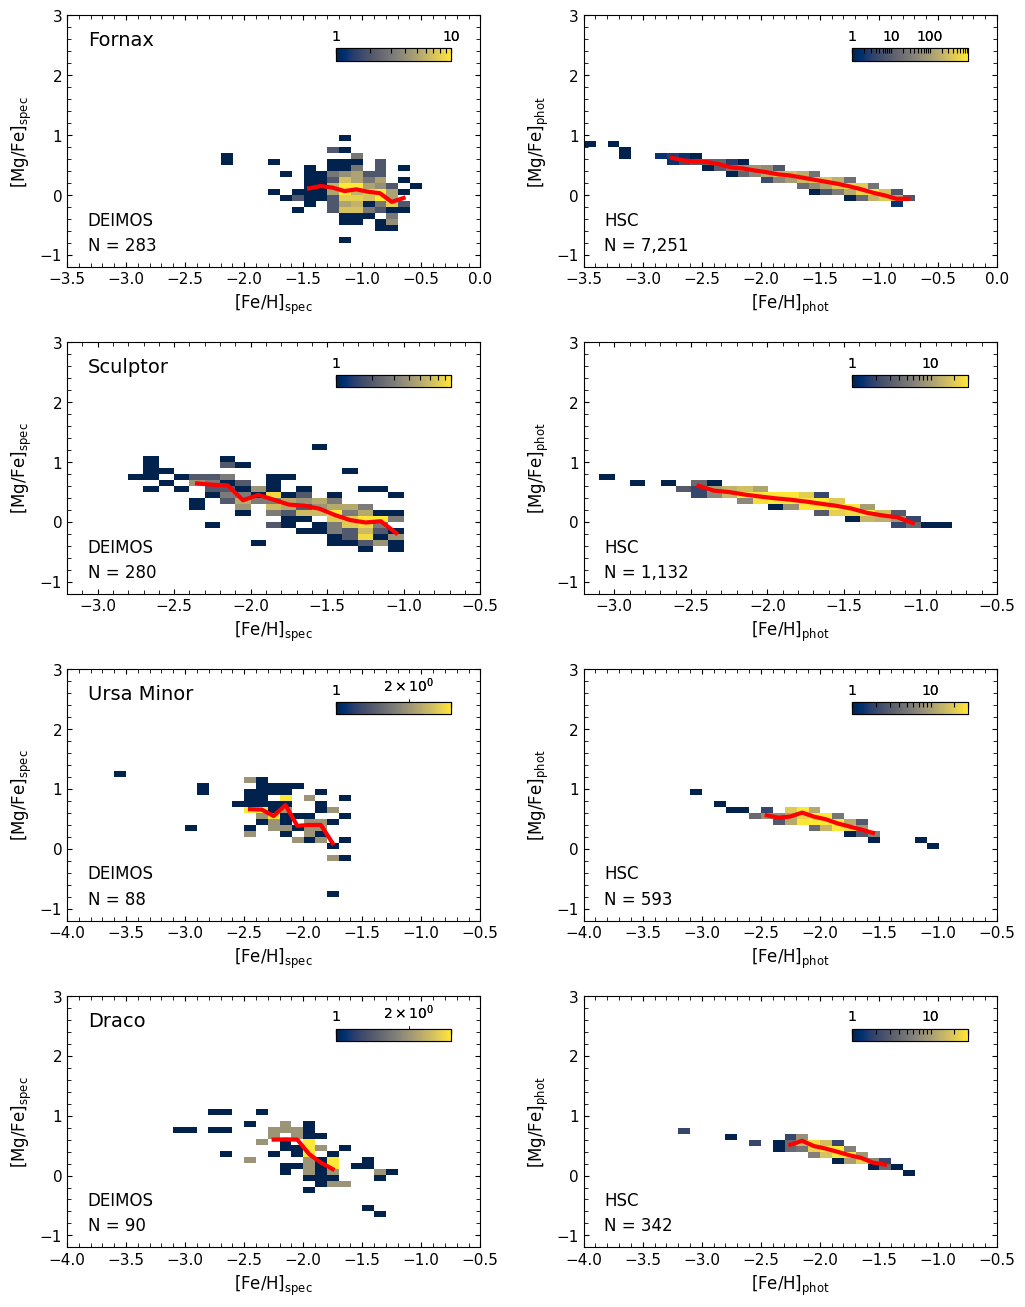

In [69]:
def plot_2d_histogram(ax, x, y, xlabel, ylabel, xlim, ylim, vmin=None, vmax=None, ticks=None):
    bins_width = 0.1
    xbins = np.arange(np.floor(np.min(x) / bins_width) * bins_width, 
                      np.ceil(np.max(x) / bins_width) * bins_width + bins_width, bins_width)
    ybins = np.arange(np.floor(np.min(y) / bins_width) * bins_width, 
                      np.ceil(np.max(y) / bins_width) * bins_width + bins_width, bins_width)

    counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))

    median_values = []
    for i in range(len(xedges) - 1):
        mask = (xedges[i] <= x) & (x < xedges[i+1])
        y_in_bin = y[mask]
        if len(y_in_bin) >= 5:
            median_values.append(np.median(y_in_bin))
        else:
            median_values.append(np.nan)

    xedges_centered = (xedges[:-1] + xedges[1:]) / 2
    median_values = median_values[:len(xedges_centered)]

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(counts.T, cmap='cividis', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    
    # Plot median line
    ax.plot(xedges_centered, median_values, color='red', label='Median', lw=3)

    # Add color bar
    cax = ax.inset_axes([0.65, 0.82, 0.28, 0.05])
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10, direction='in')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('', size=11, labelpad=4, loc='center')
    cbar.locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=5)
    cbar.formatter = LogFormatter(base=10.0, labelOnlyBase=True)
    if ticks:
        cbar.set_ticks(ticks)  # Add custom ticks
    cbar.update_ticks()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), gridspec_kw={'wspace': 0.25, 'hspace': 0.3})
(ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7) = axes

# Fornax
plot_2d_histogram(ax0, fnx_mag['FEH'], fnx_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.5, 0], [-1.2, 3], vmin=1, vmax=10)
plot_2d_histogram(ax1, hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.5, 0], [-1.2, 3])
ax0.text(0.05, 0.94, 'Fornax', ha='left', va='top', transform=ax0.transAxes, size=14)
ax0.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(fnx_mag['FEH'])), ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax1.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax1.transAxes, size=12)
ax1.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax1.transAxes, size=12)

# Sculptor
plot_2d_histogram(ax2, scl_mag['FEH'], scl_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.2, -0.5], [-1.2, 3])
plot_2d_histogram(ax3, hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.2, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax2.text(0.05, 0.94, 'Sculptor', ha='left', va='top', transform=ax2.transAxes, size=14)
ax2.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax2.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(scl_mag['FEH'])), ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax3.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax3.transAxes, size=12)
ax3.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax3.transAxes, size=12)

# Ursa Minor
plot_2d_histogram(ax4, umi_mag['FEH'], umi_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax5, hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax4.text(0.05, 0.94, 'Ursa Minor', ha='left', va='top', transform=ax4.transAxes, size=14)
ax4.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax4.transAxes, size=12)
ax4.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(umi_mag['FEH'])), ha='left', va='bottom', transform=ax4.transAxes, size=12)
#cbar.set_ticks([1, 3])
ax5.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax5.transAxes, size=12)
ax5.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax5.transAxes, size=12)

# Draco
plot_2d_histogram(ax6, dra_mag['FEH'], dra_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax7, hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax6.text(0.05, 0.94, 'Draco', ha='left', va='top', transform=ax6.transAxes, size=14)
ax6.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax6.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(dra_mag['FEH'])), ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax7.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax7.transAxes, size=12)
ax7.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax7.transAxes, size=12)


plt.savefig('compare_ann_spec_phot_mgfe_feh_hist2d_medianline.png', bbox_inches='tight')

In [70]:
def get_median_mgfe(feh_values, mgfe_values, bin_width=0.1):
    bins = np.arange(np.floor(np.min(feh_values) / bin_width) * bin_width, 
                     np.ceil(np.max(feh_values) / bin_width) * bin_width + bin_width, bin_width)
    #print(bins) #[-2.2 -2.1 -2. -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1. -0.9 -0.8 -0.7 -0.6 -0.5]
    
    median_mgfe_dict = {}
    for i in range(len(bins) - 1):
        mask = (bins[i] <= feh_values) & (feh_values < bins[i + 1])
        if np.sum(mask) >= 5:  # get median value if there are 5 data at least
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.median(mgfe_values[mask])
        else:
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.nan  # NaN if there are less than 5 stars
    
    return median_mgfe_dict

# Get median MGFE value per FEH 0.1 bin
median_mgfe_bins = get_median_mgfe(fnx_mag['FEH'], fnx_mag['MGFE'])

# Get predicted MGFE values
# Assign the median MGFE value of the corresponding FEH bin as the predicted value for each data point.
predicted_fnx_MGFE = np.array([
    median_mgfe_bins.get(
        next(((b1, b2) for (b1, b2) in median_mgfe_bins if b1 <= feh < b2), None),
        np.nan
    ) for feh in fnx_mag['FEH']
])
#print(predicted_fnx_MGFE)

"""def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def equation(err_sys):
        #numerator = np.sum((mgfe - fitted_mgfe)**2)
        #denominator = np.sum(err_mgfe**2) + (err_sys**2)
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys**2
        result = np.sum(numerator / denominator) / N
        print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        
        return result - 1
   
    err_sys_initial = 0.1
    err_sys_solution = fsolve(equation, err_sys_initial)[0]
    print('err_sys_solution =', np.abs(err_sys_solution))

    return err_sys_solution

err_sys_1 = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))

err_sys_2 = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['uncertainty_MGFE_phot_ann'], len(hsc_fnx_mag['MGFE_phot_ann']))
"""

from scipy.optimize import minimize
def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def objective(err_sys):
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys[0]**2
        result = np.sum(numerator / denominator) / N
        #print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        return (result - 1)**2  #minimize

    initial_guess = [0.1]
    bounds = [(0, None)]
    
    result = minimize(objective, x0=initial_guess, bounds=bounds)
    
    err_sys_solution = result.x[0]
    print(f"err_sys_solution: {err_sys_solution}")
    return err_sys_solution

sys_err_fnx = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))
sys_err_hsc_fnx = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['uncertainty_MGFE_phot_ann'], len(hsc_fnx_mag['MGFE_phot_ann']))

err_sys_solution: 0.14317656398425804
err_sys_solution: 0.5881356520195343


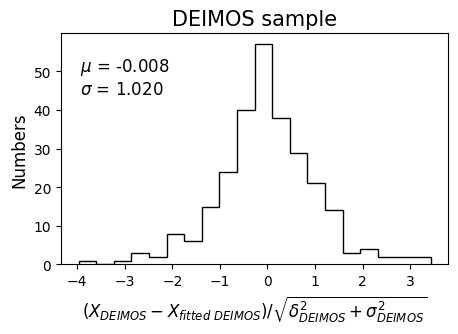

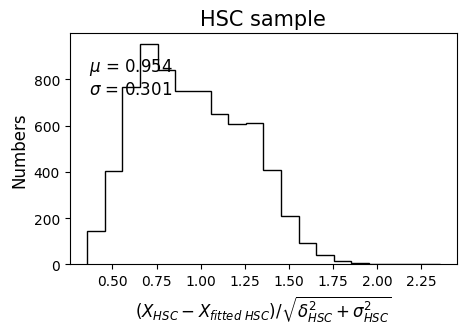

In [71]:
fig, ax0 = plt.subplots(figsize=(5,3))
x = (fnx_mag['MGFE'] - predicted_fnx_MGFE) / np.sqrt(fnx_mag['MGFEERR']**2 + sys_err_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('DEIMOS sample', size=15)
ax0.set_xlabel(r'$(X_{DEIMOS} - X_{fitted~DEIMOS}) / \sqrt{\delta_{DEIMOS}^2 + \sigma_{DEIMOS}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

print('\n')

fig, ax0 = plt.subplots(figsize=(5,3))
x = (hsc_fnx_mag['MGFE_phot_ann'] - predicted_hsc_fnx_MGFE) / np.sqrt(hsc_fnx_mag['uncertainty_MGFE_phot_ann']**2 + sys_err_hsc_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('HSC sample', size=15)
ax0.set_xlabel(r'$(X_{HSC} - X_{fitted~HSC}) / \sqrt{\delta_{HSC}^2 + \sigma_{HSC}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

In [73]:
fnx_mag_sigma = fnx_mag[
(np.abs(fnx_mag['FEH'] - np.mean(fnx_mag['FEH'])) - fnx_mag['FEHERR'] < 3 * fnx_mag['FEHERR'])
&
(np.abs(fnx_mag['MGFE'] - np.mean(fnx_mag['MGFE'])) - fnx_mag['MGFEERR'] < 3 * fnx_mag['MGFEERR'])
]
print(len(fnx_mag)) #261
print(len(fnx_mag_sigma), '\n') #224
scl_mag_sigma = scl_mag[
(np.abs(scl_mag['FEH'] - np.mean(scl_mag['FEH'])) - scl_mag['FEHERR'] < 3 * scl_mag['FEHERR'])
&
(np.abs(scl_mag['MGFE'] - np.mean(scl_mag['MGFE'])) - scl_mag['MGFEERR'] < 3 * scl_mag['MGFEERR'])
]
print(len(scl_mag)) #294
print(len(scl_mag_sigma), '\n') #184
umi_mag_sigma = umi_mag[
(np.abs(umi_mag['FEH'] - np.mean(umi_mag['FEH'])) - umi_mag['FEHERR'] < 3 * umi_mag['FEHERR'])
&
(np.abs(umi_mag['MGFE'] - np.mean(umi_mag['MGFE'])) - umi_mag['MGFEERR'] < 3 * umi_mag['MGFEERR'])
]
print(len(umi_mag)) #91
print(len(umi_mag_sigma), '\n') #74
dra_mag_sigma = dra_mag[
(np.abs(dra_mag['FEH'] - np.mean(dra_mag['FEH'])) - dra_mag['FEHERR'] < 3 * dra_mag['FEHERR'])
&
(np.abs(dra_mag['MGFE'] - np.mean(dra_mag['MGFE'])) - dra_mag['MGFEERR'] < 3 * dra_mag['MGFEERR'])
]
print(len(dra_mag)) #108
print(len(dra_mag_sigma), '\n') #82


hsc_fnx_mag_sigma = hsc_fnx_mag[
(np.abs(hsc_fnx_mag['FEH_phot_ann'] - np.mean(hsc_fnx_mag['FEH_phot_ann'])) - hsc_fnx_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_fnx_mag['uncertainty_FEH_phot_ann'])
&
(np.abs(hsc_fnx_mag['MGFE_phot_ann'] - np.mean(hsc_fnx_mag['MGFE_phot_ann'])) - hsc_fnx_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_fnx_mag['uncertainty_MGFE_phot_ann'])
]
print(len(hsc_fnx_mag)) #5514
print(len(hsc_fnx_mag_sigma), '\n') #5364
hsc_scl_mag_sigma = hsc_scl_mag[
(np.abs(hsc_scl_mag['FEH_phot_ann'] - np.mean(hsc_scl_mag['FEH_phot_ann'])) - hsc_scl_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_scl_mag['uncertainty_FEH_phot_ann'])
&
(np.abs(hsc_scl_mag['MGFE_phot_ann'] - np.mean(hsc_scl_mag['MGFE_phot_ann'])) - hsc_scl_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_scl_mag['uncertainty_MGFE_phot_ann'])
]
print(len(hsc_scl_mag)) #1205
print(len(hsc_scl_mag_sigma), '\n') #1078
hsc_umi_mag_sigma = hsc_umi_mag[
(np.abs(hsc_umi_mag['FEH_phot_ann'] - np.mean(hsc_umi_mag['FEH_phot_ann'])) - hsc_umi_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_umi_mag['uncertainty_FEH_phot_ann'])
&
(np.abs(hsc_umi_mag['MGFE_phot_ann'] - np.mean(hsc_umi_mag['MGFE_phot_ann'])) - hsc_umi_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_umi_mag['uncertainty_MGFE_phot_ann'])
]
print(len(hsc_umi_mag)) #647
print(len(hsc_umi_mag_sigma), '\n') #630
hsc_dra_mag_sigma = hsc_dra_mag[
(np.abs(hsc_dra_mag['FEH_phot_ann'] - np.mean(hsc_dra_mag['FEH_phot_ann'])) - hsc_dra_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_dra_mag['uncertainty_FEH_phot_ann'])
&
(np.abs(hsc_dra_mag['MGFE_phot_ann'] - np.mean(hsc_dra_mag['MGFE_phot_ann'])) - hsc_dra_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_dra_mag['uncertainty_MGFE_phot_ann'])
]
print(len(hsc_dra_mag)) #469
print(len(hsc_dra_mag_sigma)) #444

283
235 

280
169 

88
70 

90
64 

7251
6826 

1132
1100 

593
591 

342
339


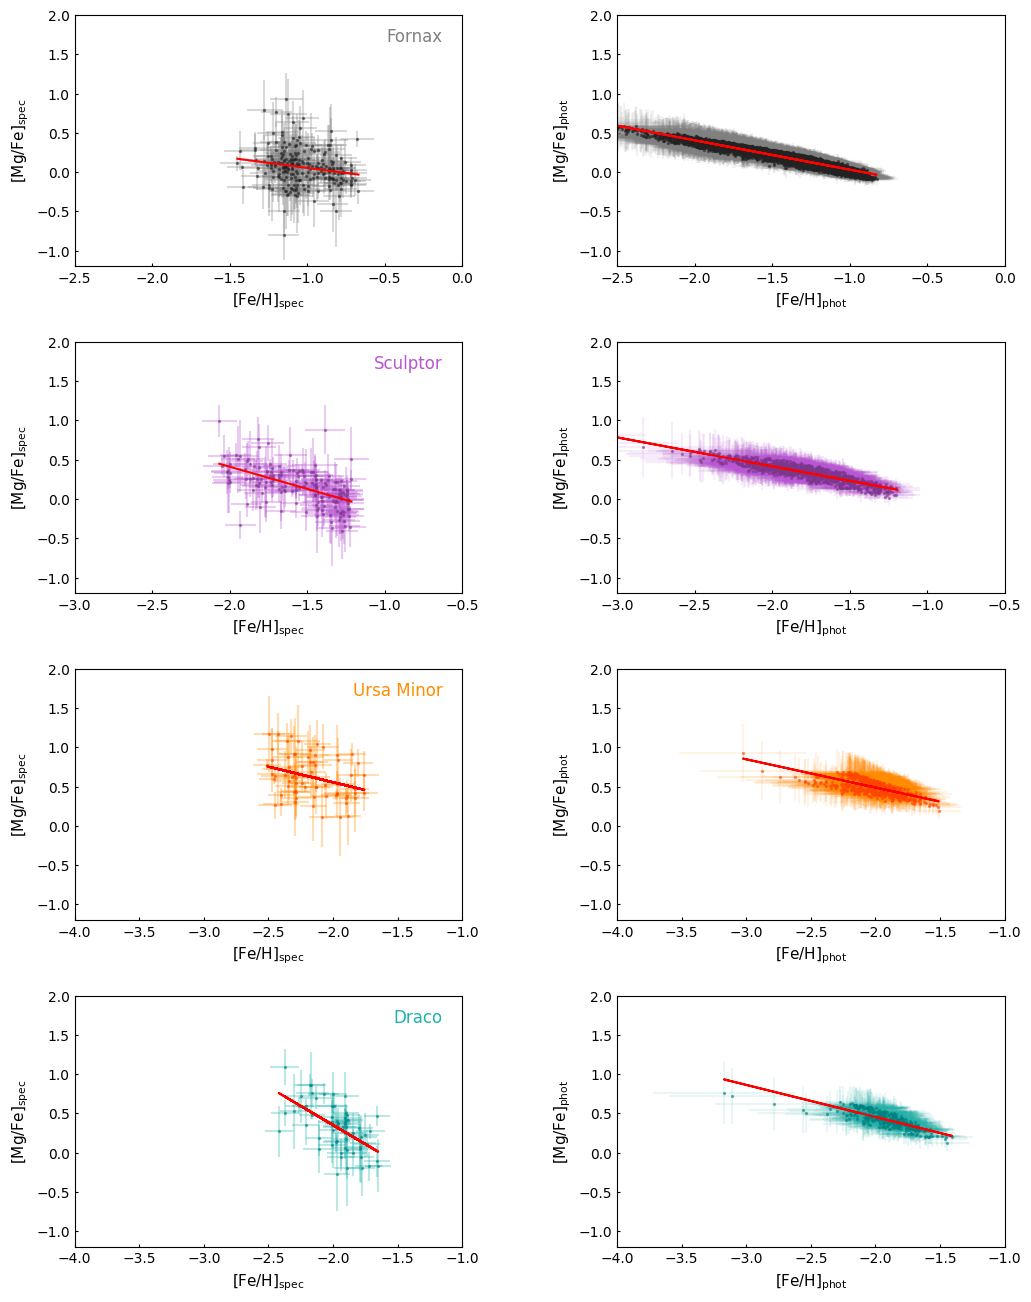

In [76]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12,16), gridspec_kw={'wspace':0.4, 'hspace':0.3})
s = 2 ; alpha = 0.5 ; markersize=0

# Fnx
ax0.errorbar(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], xerr=fnx_mag_sigma['FEHERR'], yerr=fnx_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='gray')
ax0.scatter(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax0.set_xlim([-2.5, 0])
ax0.set_ylim([-1.2, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.95, 0.95, 'Fornax', ha='right', va='top', transform=ax0.transAxes, color='gray', size=12)
slope, intercept = np.polyfit(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], 1)
ax0.plot(fnx_mag_sigma['FEH'], slope * fnx_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax1.errorbar(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], xerr=hsc_fnx_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_fnx_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='gray')
ax1.scatter(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax1.set_xlim([-2.5, 0])
ax1.set_ylim([-1.2, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], 1)
ax1.plot(hsc_fnx_mag_sigma['FEH_phot_ann'], slope * hsc_fnx_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Scl
ax2.errorbar(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], xerr=scl_mag_sigma['FEHERR'], yerr=scl_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='mediumorchid')
ax2.scatter(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax2.set_xlim([-3, -0.5])
ax2.set_ylim([-1.2, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.95, 0.95, 'Sculptor', ha='right', va='top', transform=ax2.transAxes, color='mediumorchid', size=12)
slope, intercept = np.polyfit(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], 1)
ax2.plot(scl_mag_sigma['FEH'], slope * scl_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax3.errorbar(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], xerr=hsc_scl_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_scl_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='mediumorchid')
ax3.scatter(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax3.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax3.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax3.set_xlim([-3, -0.5])
ax3.set_ylim([-1.2, 2])
ax3.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax3.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], 1)
ax3.plot(hsc_scl_mag_sigma['FEH_phot_ann'], slope * hsc_scl_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# UMi
ax4.errorbar(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], xerr=umi_mag_sigma['FEHERR'], yerr=umi_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='darkorange')
ax4.scatter(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax4.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax4.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax4.set_xlim([-4, -1])
ax4.set_ylim([-1.2, 2])
ax4.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.text(0.95, 0.95, 'Ursa Minor', ha='right', va='top', transform=ax4.transAxes, color='darkorange', size=12)
slope, intercept = np.polyfit(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], 1)
ax4.plot(umi_mag_sigma['FEH'], slope * umi_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax5.errorbar(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], xerr=hsc_umi_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_umi_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='darkorange')
ax5.scatter(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax5.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax5.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax5.set_xlim([-4, -1])
ax5.set_ylim([-1.2, 2])
ax5.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax5.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], 1)
ax5.plot(hsc_umi_mag_sigma['FEH_phot_ann'], slope * hsc_umi_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Dra
ax6.errorbar(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], xerr=dra_mag_sigma['FEHERR'], yerr=dra_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='lightseagreen')
ax6.scatter(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax6.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax6.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax6.set_xlim([-4, -1])
ax6.set_ylim([-1.2, 2])
ax6.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.text(0.95, 0.95, 'Draco', ha='right', va='top', transform=ax6.transAxes, color='lightseagreen', size=12)
slope, intercept = np.polyfit(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], 1)
ax6.plot(dra_mag_sigma['FEH'], slope * dra_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax7.errorbar(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], xerr=hsc_dra_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_dra_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='lightseagreen')
ax7.scatter(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax7.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax7.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax7.set_xlim([-4, -1])
ax7.set_ylim([-1.2, 2])
ax7.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax7.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], 1)
ax7.plot(hsc_dra_mag_sigma['FEH_phot_ann'], slope * hsc_dra_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_w_line.png', bbox_inches='tight')

In [ ]:
# Simple comparison version

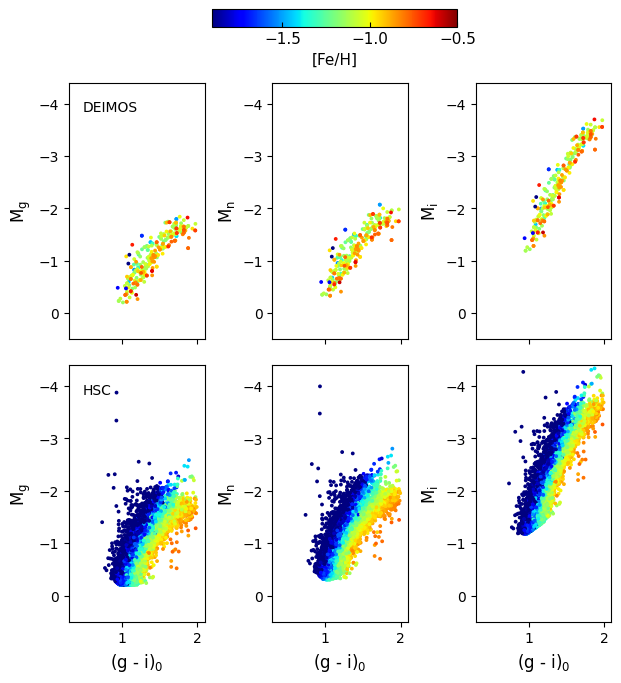

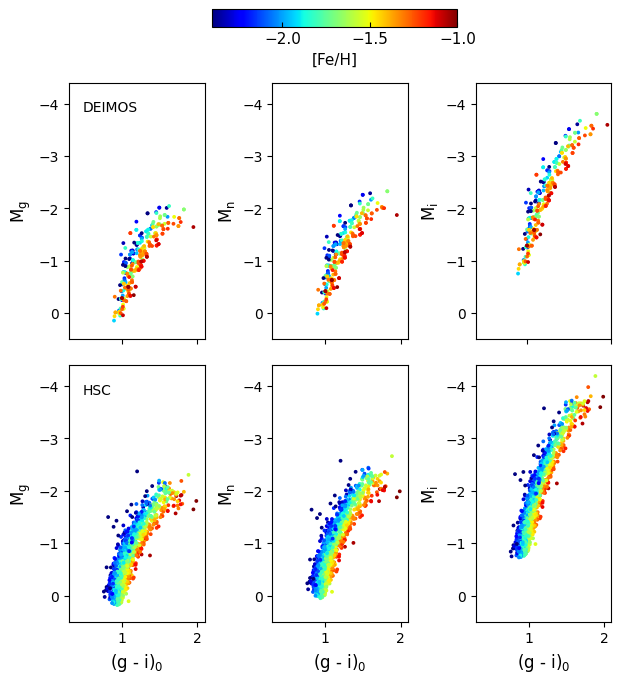

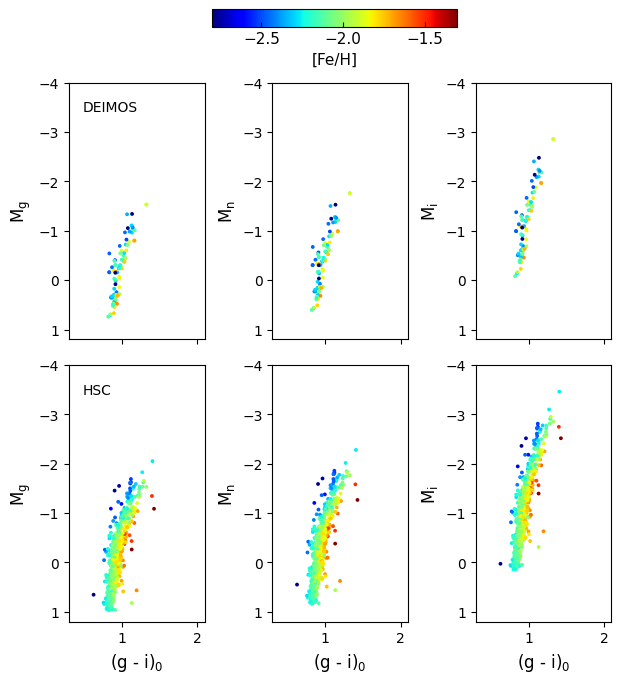

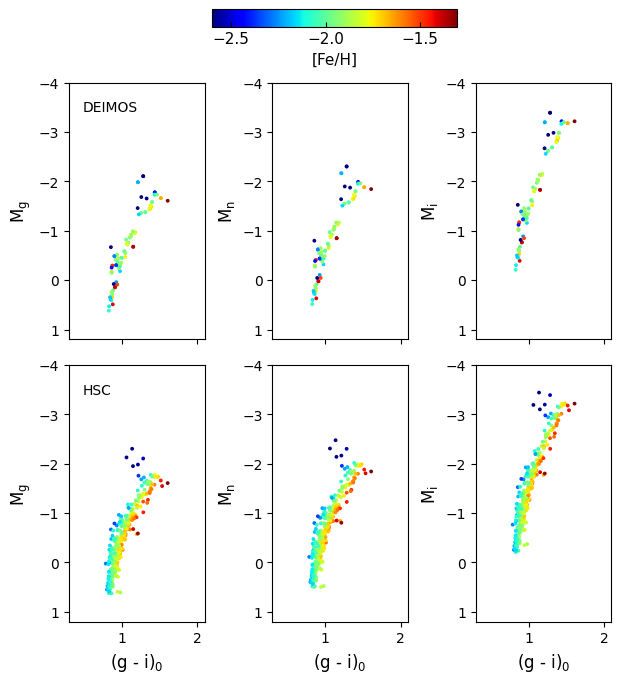

In [77]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

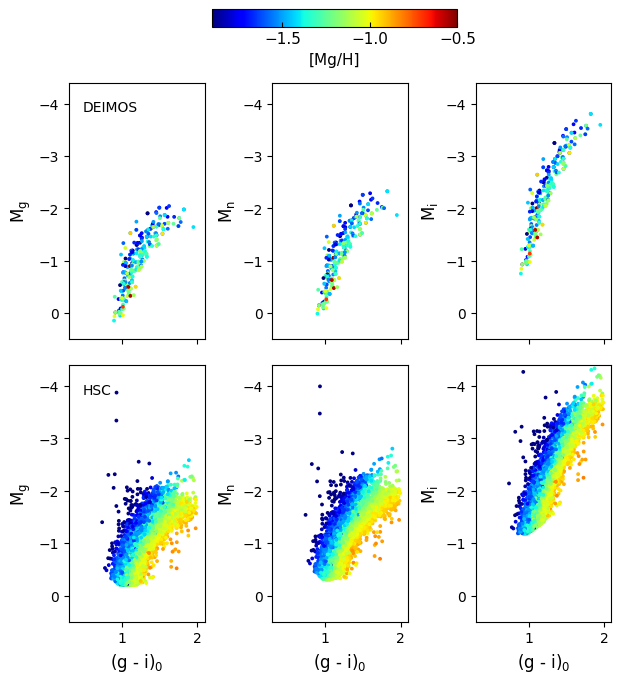

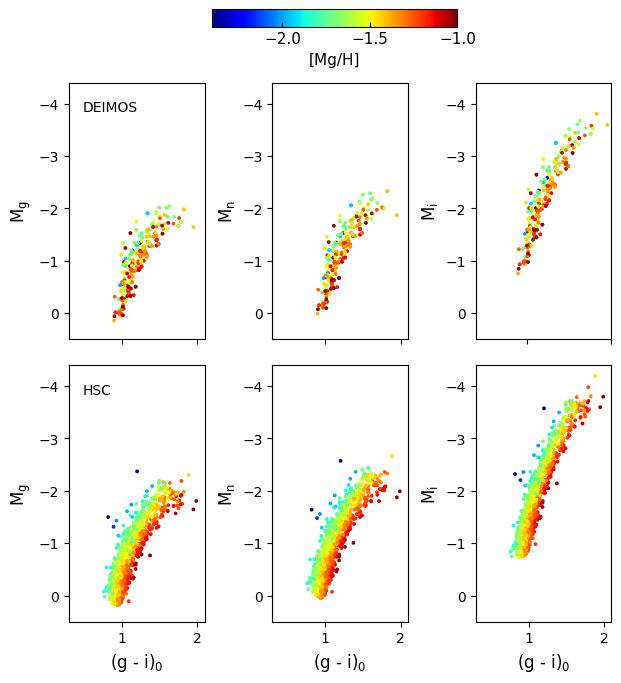

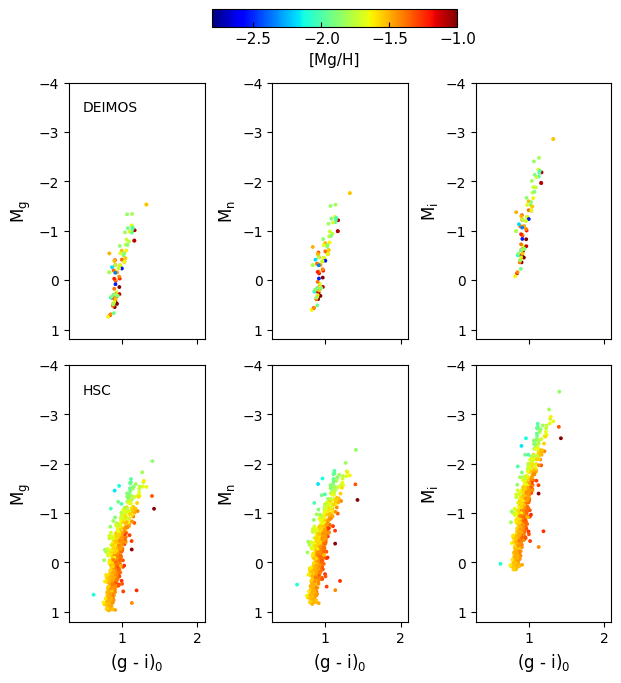

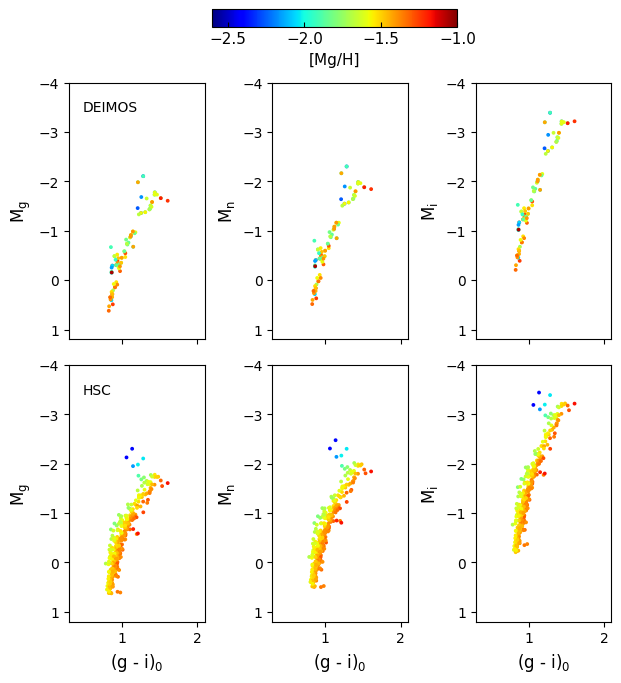

In [78]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

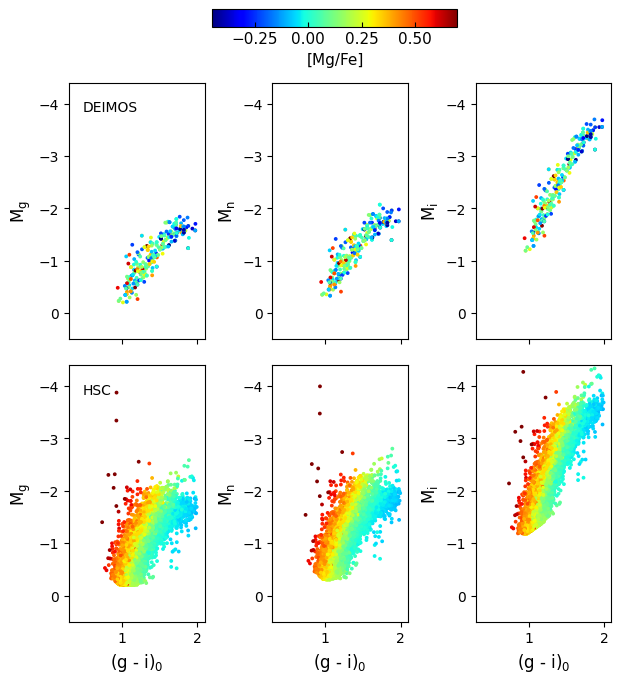

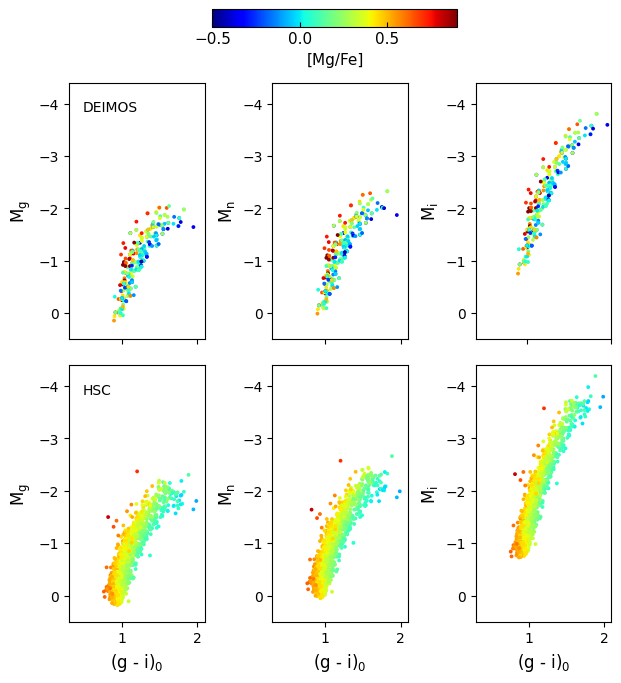

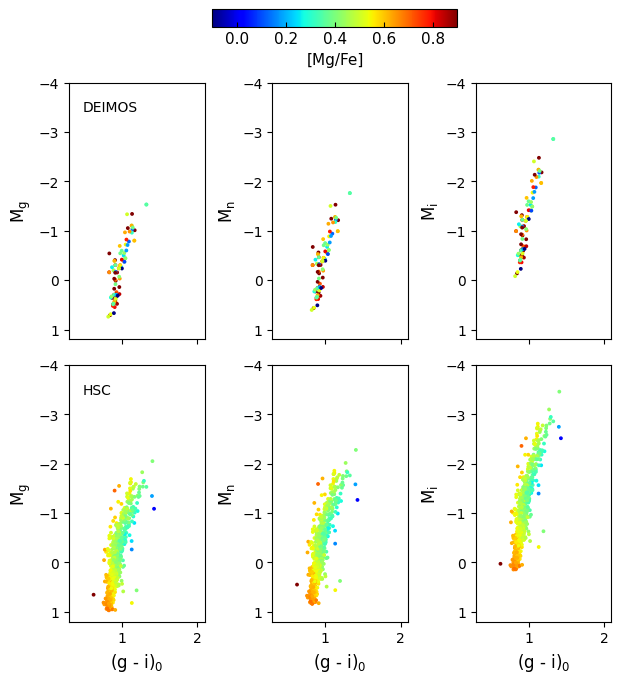

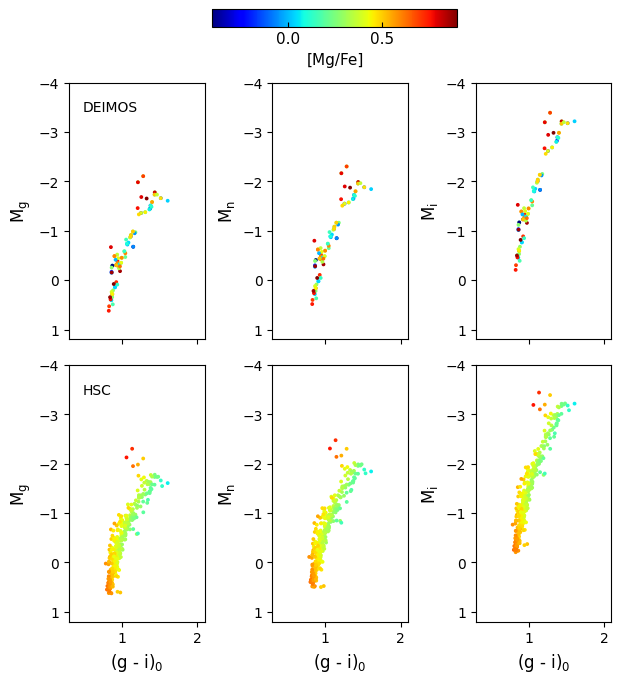

In [79]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.5 ; vmax =0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')

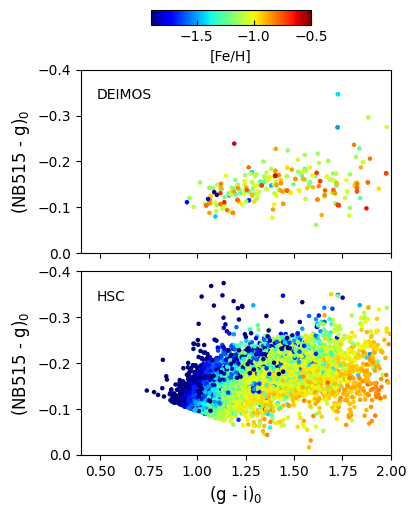

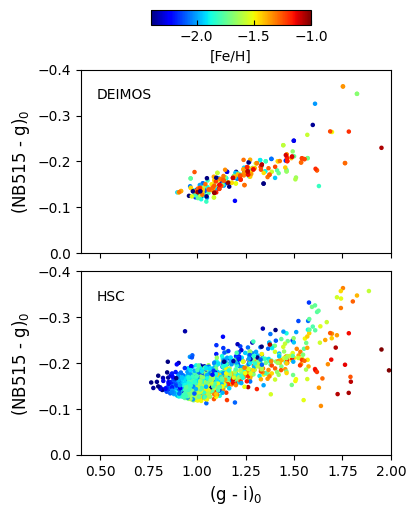

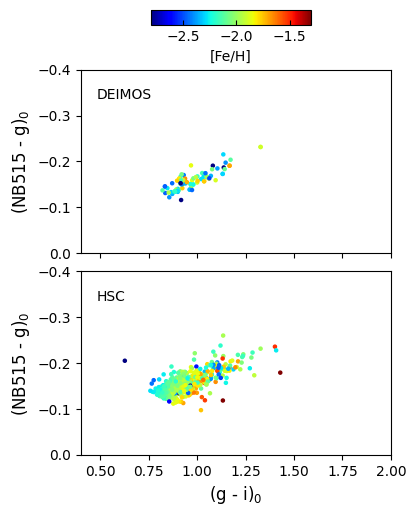

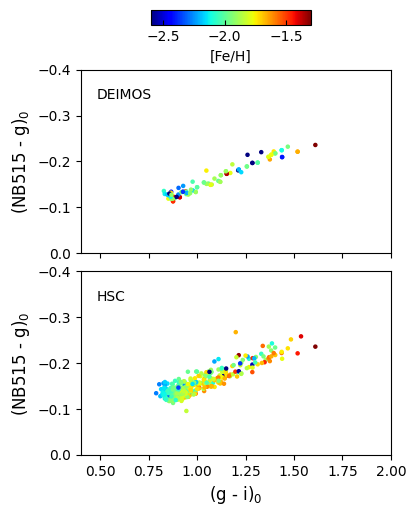

In [80]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')

# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

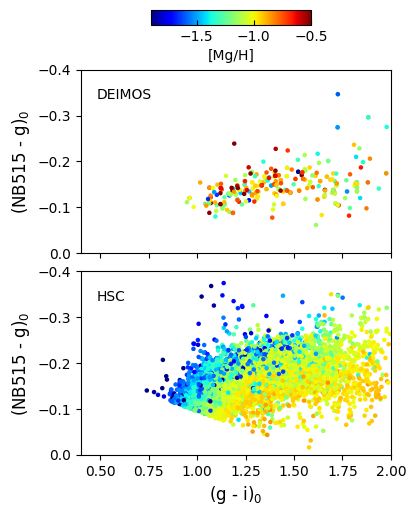

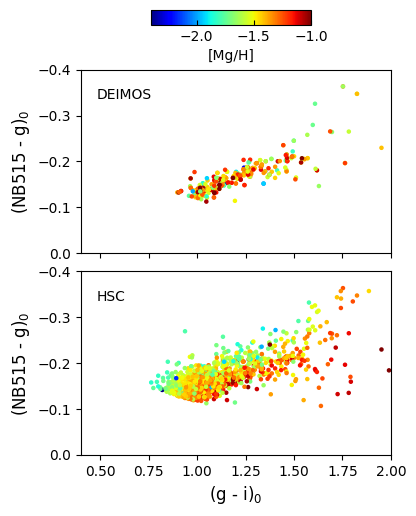

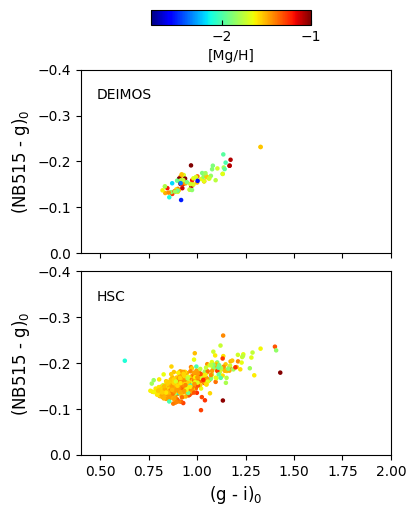

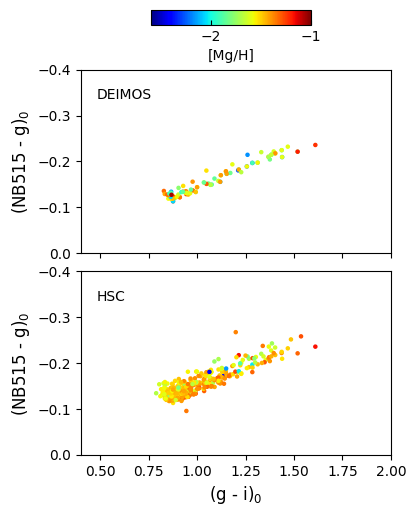

In [82]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

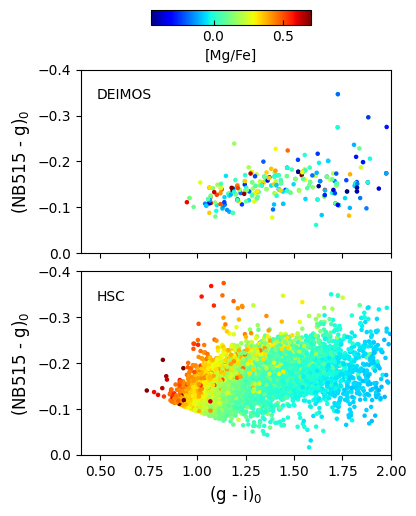

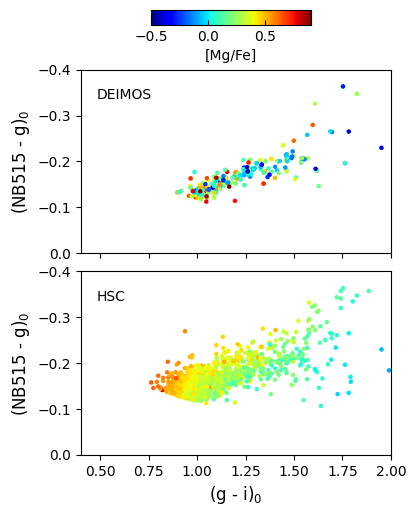

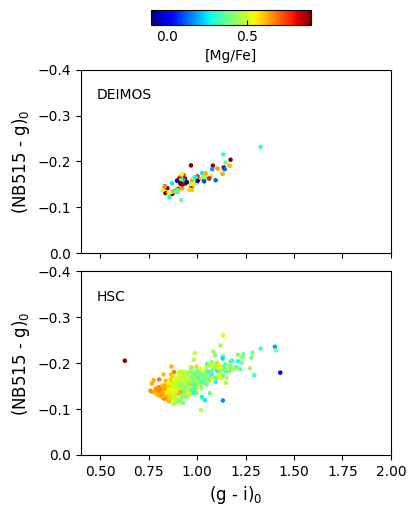

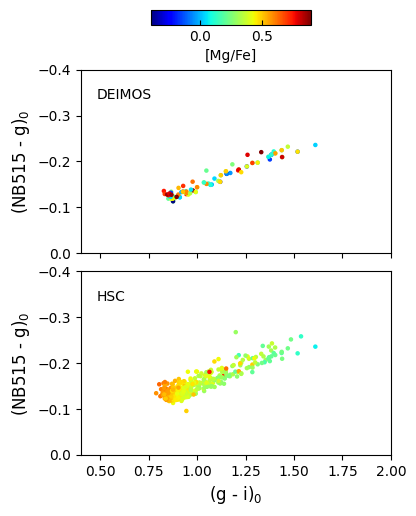

In [83]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.5 ; vmax = 0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')